# Fine-Tuning Qwen2-VL-7B for object detection

## 🖥️ GPU Configuration and Selection

**AUTOMATIC GPU SELECTION**: The script automatically finds available GPUs!

**Original Paper Requirements:**
- Recommended: 2x A6000 (48GB each) or 1x A100 (40/80GB)
- Your hardware: RTX 6000 Ada (48GB) - equivalent to A6000

**How it works:**
1. Automatically scans all GPUs for availability
2. Selects GPUs with <2GB memory used and <10% utilization
3. Can use 1 or 2 GPUs (configurable with `prefer_multi_gpu`)
4. Falls back to the GPU with most free memory if auto-selection fails

**To use 2 GPUs** (like original paper): Set `prefer_multi_gpu=True` below

In [ ]:
# GPU CONFIGURATION - MUST RUN FIRST!
import os
import sys
import subprocess
# Note: torch import moved below after setting CUDA_VISIBLE_DEVICES

# Set memory management for better GPU utilization
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# CONFIGURATION: Set this based on your needs
# Original paper uses 2x A6000 (48GB each), but 1x RTX 6000 Ada (48GB) may be sufficient
USE_DUAL_GPU = True  # Set to True to use 2 GPUs like the original paper, False for 1 GPU
MAX_GPUS = 2  # Maximum number of GPUs to use (to avoid occupying all lab resources)

print("=" * 60)
print("🖥️  AUTOMATIC GPU CONFIGURATION")
print("=" * 60)

# Function to find available GPUs
def find_available_gpus(num_gpus_needed=1):
    """Find available GPUs by checking memory usage."""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=index,memory.used,memory.total', 
             '--format=csv,noheader,nounits'],
            capture_output=True, text=True, check=True
        )
        
        available = []
        for line in result.stdout.strip().split('\n'):
            parts = line.split(',')
            gpu_idx = int(parts[0])
            mem_used = int(parts[1])
            mem_total = int(parts[2])
            
            # Consider GPU available if <2GB used and has at least 40GB total
            if mem_used < 2000 and mem_total > 40000:
                available.append(gpu_idx)
        
        # Return exactly the number of GPUs requested (not more!)
        # IMPORTANT: This ensures we only use the requested number of GPUs
        # to avoid occupying all lab resources
        if len(available) >= num_gpus_needed:
            return available[:num_gpus_needed]  # Take ONLY what we need, not all available
        else:
            return available  # Return what we have (might be less than requested)
            
    except Exception as e:
        print(f"Error checking GPUs: {e}")
        return []

# Determine how many GPUs to use (enforce MAX_GPUS limit)
num_gpus = 2 if USE_DUAL_GPU else 1
num_gpus = min(num_gpus, MAX_GPUS)  # Never exceed MAX_GPUS
print(f"Configuration: {'DUAL GPU (like original paper)' if USE_DUAL_GPU else 'SINGLE GPU (test mode)'}")
print(f"Looking for {num_gpus} available GPU(s) (max {MAX_GPUS} to preserve lab resources)...")

# Find available GPUs
available_gpus = find_available_gpus(num_gpus)

if len(available_gpus) > 0:
    # Ensure we never use more than MAX_GPUS even if more are found
    available_gpus = available_gpus[:MAX_GPUS]
    gpu_string = ','.join(str(g) for g in available_gpus)
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_string
    print(f"✅ Found {len(available_gpus)} available GPU(s): {available_gpus}")
    if USE_DUAL_GPU and len(available_gpus) == 1:
        print("⚠️ Warning: Only 1 GPU available, but 2 were requested")
else:
    # Try to find ANY available GPU as fallback
    print("⚠️ No free GPUs found with standard criteria, checking all GPUs...")
    
    # Try to find the GPU with most free memory
    best_gpu = None
    best_free_mem = 0
    
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=index,memory.used,memory.total', 
             '--format=csv,noheader,nounits'],
            capture_output=True, text=True, check=True
        )
        
        for line in result.stdout.strip().split('\n'):
            parts = line.split(',')
            gpu_idx = int(parts[0])
            mem_used = int(parts[1])
            mem_total = int(parts[2])
            free_mem = mem_total - mem_used
            
            print(f"   GPU {gpu_idx}: {free_mem/1024:.1f} GB free")
            
            if free_mem > best_free_mem and free_mem > 20000:  # At least 20GB free
                best_gpu = gpu_idx
                best_free_mem = free_mem
    except:
        pass
    
    if best_gpu is not None:
        # For fallback, still respect the MAX_GPUS limit (use only 1 GPU in fallback)
        os.environ["CUDA_VISIBLE_DEVICES"] = str(best_gpu)
        print(f"✅ Using GPU {best_gpu} with {best_free_mem/1024:.1f} GB free memory")
        print(f"   (Using single GPU in fallback mode to preserve lab resources)")
    else:
        print("❌ No GPUs available with sufficient memory!")
        print("   Please free up GPU memory or wait for GPUs to become available")
        sys.exit(1)

# Verify configuration
print(f"\nCUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")

# Import torch AFTER setting CUDA_VISIBLE_DEVICES
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    total_memory = 0
    print(f"PyTorch sees {device_count} GPU(s):")
    
    # Verify we're not using more than MAX_GPUS
    if device_count > MAX_GPUS:
        print(f"⚠️ ERROR: PyTorch sees {device_count} GPUs but MAX_GPUS={MAX_GPUS}")
        print("   This should not happen - CUDA_VISIBLE_DEVICES may not be set correctly")
        
    for i in range(device_count):
        mem_gb = torch.cuda.get_device_properties(i).total_memory / 1024**3
        total_memory += mem_gb
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)} ({mem_gb:.1f} GB)")
    print(f"\nTotal GPU memory available: {total_memory:.1f} GB")
    
    # Final confirmation
    print(f"\n✅ CONFIRMED: Using exactly {device_count} GPU(s) (max allowed: {MAX_GPUS})")
    
    if device_count > 1:
        print("\n📝 Multi-GPU Training Notes:")
        print("  - Model will automatically use DataParallel")
        print("  - Effective batch size = per_device_batch_size × 2")
else:
    print("❌ CUDA not available! Exiting...")
    sys.exit(1)

print("=" * 60)

🖥️  AUTOMATIC GPU CONFIGURATION
Configuration: DUAL GPU (like original paper)
Looking for 2 available GPU(s) (max 2 to preserve lab resources)...
✅ Found 2 available GPU(s): [0, 1]

CUDA_VISIBLE_DEVICES: 0,1
PyTorch sees 2 GPU(s):
  GPU 0: NVIDIA RTX 6000 Ada Generation (47.5 GB)
  GPU 1: NVIDIA RTX 6000 Ada Generation (47.5 GB)

Total GPU memory available: 95.0 GB

✅ CONFIRMED: Using exactly 2 GPU(s) (max allowed: 2)

📝 Multi-GPU Training Notes:
  - Model will automatically use DataParallel
  - Effective batch size = per_device_batch_size × 2


## 🌟 WHAT?

In this notebook, you will learn how to fine-tune [Qwen2-VL-7B](https://qwenlm.github.io/blog/qwen2-vl/) for for detecting nutrition tables from product images using Hugging Face.

![Image of nutrition table detection](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*tcy5oCWmHT3jeVN7Lw-FpQ.png)

💡 You can execute this Jupyter Notebook on a remote machine and then access and interact with it in your local web browser, leveraging the remote machine's computational resources.
- On remote: jupyter notebook --no-browser --port=8080
- On local: ssh -L 8080:localhost:8080 ntajbakhsh@workstation

🚨 **WARNING**: Please note that QWEN2-VL-7B is a relatively large model, requiring significant computational resources for fine-tuning. I recommend using either 2x A6000 or 1x A100 GPUs to ensure sufficient memory and processing power. While I haven't experimented with other GPUs, you're welcome to try alternative options. However, please be aware that other GPUs may not have enough memory to accommodate the model and optimizer states during training.

🚨 **WARNING**: Training transformers can be significantly more memory-efficient with Flash Attention (FA) compared to traditional attention mechanisms. However, FA support is currently limited to Nvidia's Ampere series of GPUs (A100, A6000, etc.) or better. If you're using an older GPU generation, please note that you'll need to disable FA to avoid error messages. Keep in mind that disabling FA may require using additional GPUs to compensate for the reduced memory efficiency.


# 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [ ]:
# SKIP THIS CELL - Already installed in environment
# !pip install  -U -q git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git datasets bitsandbytes peft qwen-vl-utils wandb accelerate
# Tested with transformers==4.47.0.dev0, trl==0.12.0.dev0, datasets==3.0.2, bitsandbytes==0.44.1, peft==0.13.2, qwen-vl-utils==0.0.8, wandb==0.18.5, accelerate==1.0.1
# !pip install  matplotlib IPython
print("✅ Dependencies already installed in conda environment")

✅ Dependencies already installed in conda environment


We’ll also need to install an earlier version of *PyTorch*, as the latest version has an issue that currently prevents this notebook from running correctly. You can learn more about the issue [here](https://github.com/pytorch/pytorch/issues/138340) and consider updating to the latest version once it’s resolved.

In [ ]:
# SKIP THIS CELL - PyTorch already installed
# !pip install -q torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121
print("✅ PyTorch 2.4.1 with CUDA 12.1 already installed")

✅ PyTorch 2.4.1 with CUDA 12.1 already installed


# 2. HF Login

Log in to Hugging Face to upload your fine-tuned model! 🗝️

You’ll need to authenticate with your Hugging Face account to save and share your model directly from this notebook.


In [ ]:
from huggingface_hub import login
import os
login(token=os.environ['HF_TOKEN']) # export your HF_TOKEN first. You can add this to your ~/.bashrc.

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Optional Settings for an Improved Jupyter Experience

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# 2. Load and Understand Dataset 📁

In this section, you should load the [openfoodfacts/nutrition-table-detection](https://huggingface.co/datasets/openfoodfacts/nutrition-table-detection) dataset. This dataset contains product images, the extracted bar codes, and bounding boxes for the nutrition tables.

📚 **Note**: For detailed dataset exploration and analysis, see [`notebooks/01_dataset_exploration.ipynb`](notebooks/01_dataset_exploration.ipynb).

That notebook provides in-depth analysis including:
- Image size distributions and statistics
- Bounding box characteristics (aspect ratios, coverage, positions)
- Visualization of multiple examples
- Recommendations for anchor configuration

Below shows a streamlined version sufficient for understanding the training pipeline.

In [ ]:
# TASK: load the dataset into training and evaluation sets
from datasets import load_dataset
dataset_id = "openfoodfacts/nutrition-table-detection"

# Load the dataset with train and validation splits
ds = load_dataset(dataset_id)

# inspect the dataset
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(ds)

# split the dataset into training and evaluation sets
train_dataset = ds['train']
eval_dataset = ds['val']  

print("\n" + "=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")
print(f"Dataset features: {train_dataset.features}")

DATASET OVERVIEW
DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'meta', 'objects'],
        num_rows: 1083
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'meta', 'objects'],
        num_rows: 123
    })
})

DATASET STATISTICS
Training samples: 1083
Validation samples: 123
Dataset features: {'image_id': Value('string'), 'image': Image(mode=None, decode=True), 'width': Value('int64'), 'height': Value('int64'), 'meta': {'barcode': Value('string'), 'off_image_id': Value('string'), 'image_url': Value('string')}, 'objects': {'bbox': List(List(Value('float32'))), 'category_id': List(Value('int64')), 'category_name': List(Value('string'))}}


In [ ]:
# TASK: inspect the content of a training example
# Let's look at the first training example
import pprint

print("=" * 60)
print("DATASET FEATURES BREAKDOWN")
print("=" * 60)

print("\n📋 FEATURE SCHEMA:")
for feature_name, feature_type in train_dataset.features.items():
    print(f"  {feature_name:12} : {feature_type}")

print("\n" + "=" * 60)
print("INSPECTING train_dataset[0] - FIRST TRAINING EXAMPLE")
print("=" * 60)

example = train_dataset[0]

print(f"\n🔍 COMPLETE RAW DATA FOR train_dataset[0]:")
print(f"\ntrain_dataset[0]['image_id']:")
print(f"  {example['image_id']}")

print(f"\ntrain_dataset[0]['image']:")
print(f"  {example['image']}")

print(f"\ntrain_dataset[0]['width']:")
print(f"  {example['width']}")

print(f"\ntrain_dataset[0]['height']:")
print(f"  {example['height']}")

print(f"\ntrain_dataset[0]['meta']:")
pp = pprint.PrettyPrinter(indent=4, width=80)
pp.pprint(example['meta'])

print(f"\ntrain_dataset[0]['objects']:")
pp.pprint(example['objects'])

print(f"\n📝 SUMMARY:")
print(f"  We are examining: train_dataset[0] (first element of training set)")
print(f"  Total keys in this example: {list(example.keys())}")

print("\n" + "=" * 60)
print("HUMAN-READABLE SUMMARY")
print("=" * 60)
print("Now let's format the same data in a more readable way:")

print(f"\n🆔 BASIC INFO:")
print(f"  Image ID     : {example['image_id']}")
print(f"  Dimensions   : {example['width']} x {example['height']}")
print(f"  Image Object : {example['image']}")

print(f"\n📊 METADATA:")
pp.pprint(example['meta'])

print(f"\n🎯 ANNOTATIONS:")
print(f"  Number of objects: {len(example['objects']['category_name'])}")
print(f"  Category name       : {example['objects']['category_name']}")
print(f"  Category IDs     : {example['objects']['category_id']}")
print(f"  Bounding boxes   :")
for i, bbox in enumerate(example['objects']['bbox']):
    print(f"    Object {i}: [y_min={bbox[0]:.3f}, x_min={bbox[1]:.3f}, y_max={bbox[2]:.3f}, x_max={bbox[3]:.3f}]")

DATASET FEATURES BREAKDOWN

📋 FEATURE SCHEMA:
  image_id     : Value('string')
  image        : Image(mode=None, decode=True)
  width        : Value('int64')
  height       : Value('int64')
  meta         : {'barcode': Value('string'), 'off_image_id': Value('string'), 'image_url': Value('string')}
  objects      : {'bbox': List(List(Value('float32'))), 'category_id': List(Value('int64')), 'category_name': List(Value('string'))}

INSPECTING train_dataset[0] - FIRST TRAINING EXAMPLE

🔍 COMPLETE RAW DATA FOR train_dataset[0]:

train_dataset[0]['image_id']:
  0009800892204_1

train_dataset[0]['image']:
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x7F51D1D80DC0>

train_dataset[0]['width']:
  2592

train_dataset[0]['height']:
  1944

train_dataset[0]['meta']:
{   'barcode': '0009800892204',
    'image_url': 'https://static.openfoodfacts.org/images/products/000/980/089/2204/1.jpg',
    'off_image_id': '1'}

train_dataset[0]['objects']:
{   'bbox': [   [   0.057098764


IMAGE VISUALIZATION
Displaying original image vs. image with bounding box overlay:

⚠️ Checking dimensions:
  Dataset width x height: 2592 x 1944
  PIL image size: 2592 x 1944

📦 Raw bbox values (normalized [0,1]):
  bbox = [0.057098764926195145, 0.014274691231548786, 0.603501558303833, 0.991126537322998]
  Format: [y_min, x_min, y_max, x_max] (OpenFoodFacts convention)

📐 Converted to pixels:
  Pixel coords - Top-left: (37.0, 111.0)
  Pixel coords - Bottom-right: (2569.0, 1173.2)
  Box size: 2532.0 x 1062.2 pixels
  Image size: 2592 x 1944 pixels


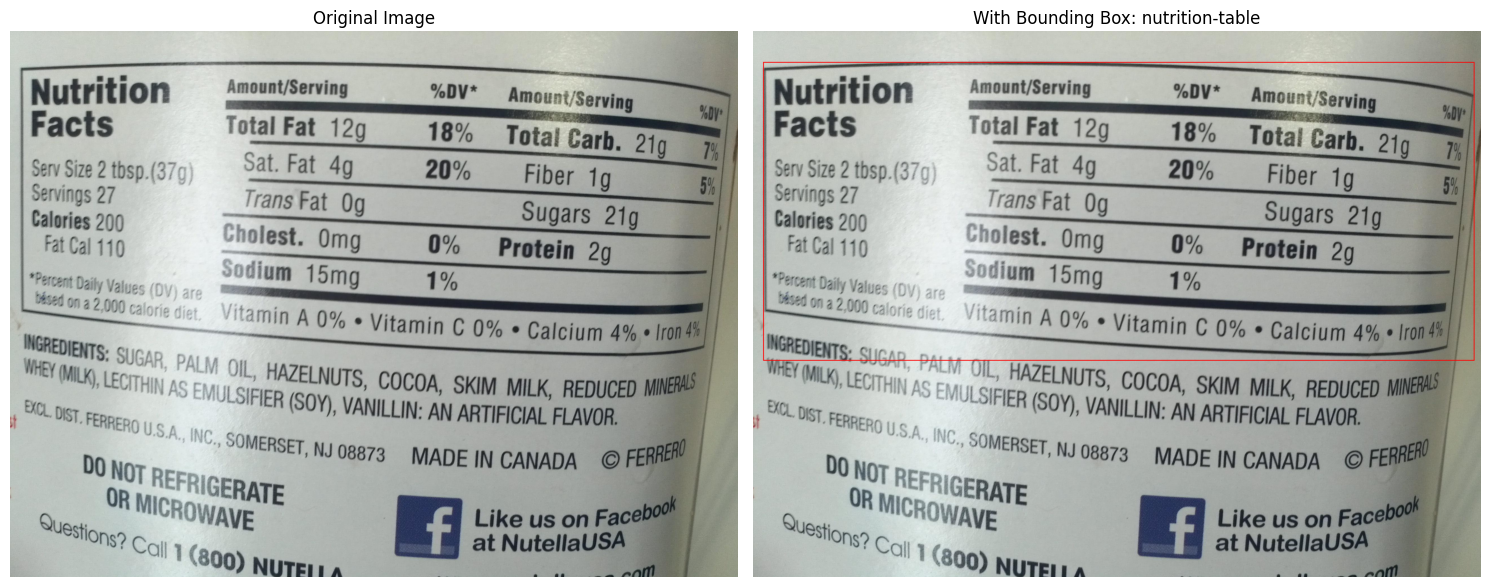


✅ Visualization complete!
   Category detected: nutrition-table
   Image dimensions: 2592 x 1944 pixels

✅ BBOX Format Confirmed: OpenFoodFacts uses [y_min, x_min, y_max, x_max]
   Image aspect ratio: 1.33
   BBox aspect ratio: 2.38


In [ ]:
# Q: why the bbox coordinates are between 0 and 1? can you overlay the bbox on the image for one example?

# The bbox coordinates are normalized to [0, 1] to make them resolution-independent.
# This is a common practice in object detection to handle images of different sizes.

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# TASK: display the image with bounding box

print("\n" + "=" * 60)
print("IMAGE VISUALIZATION")
print("=" * 60)
print("Displaying original image vs. image with bounding box overlay:")

# Get the bounding box coordinates (already normalized to 0-1 from dataset)
bbox = example['objects']['bbox'][0]

# IMPORTANT: Check dataset dimensions vs PIL image dimensions
width = example['width']
height = example['height']
pil_width, pil_height = example['image'].size

print(f"\n⚠️ Checking dimensions:")
print(f"  Dataset width x height: {width} x {height}")
print(f"  PIL image size: {pil_width} x {pil_height}")

# Show the raw bbox values for reference
print(f"\n📦 Raw bbox values (normalized [0,1]):")
print(f"  bbox = {bbox}")
print(f"  Format: [y_min, x_min, y_max, x_max] (OpenFoodFacts convention)")

# CRITICAL: Always use PIL dimensions for visualization since we're drawing on PIL image
# The dataset bbox is normalized [0,1] regardless of actual image size
width = pil_width
height = pil_height

# Convert normalized [0,1] coordinates to pixel coordinates
# CRITICAL: OpenFoodFacts dataset format is [y_min, x_min, y_max, x_max] NOT [x_min, y_min, x_max, y_max]!
y_min, x_min, y_max, x_max = bbox  # Unpack in correct order
x_min = x_min * width
y_min = y_min * height
x_max = x_max * width
y_max = y_max * height

print(f"\n📐 Converted to pixels:")
print(f"  Pixel coords - Top-left: ({x_min:.1f}, {y_min:.1f})")
print(f"  Pixel coords - Bottom-right: ({x_max:.1f}, {y_max:.1f})")
print(f"  Box size: {x_max-x_min:.1f} x {y_max-y_min:.1f} pixels")
print(f"  Image size: {width} x {height} pixels")

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Original image (should be clean, no bounding box)
_ = ax1.imshow(example['image'])
_ = ax1.set_title("Original Image")
_ = ax1.axis('off')

# Right: Image with bounding box overlay
img_with_bbox = example['image'].copy()  # Important: make a copy to avoid modifying original
draw = ImageDraw.Draw(img_with_bbox)

# Draw the bounding box
draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=3)

_ = ax2.imshow(img_with_bbox)
_ = ax2.set_title(f"With Bounding Box: {example['objects']['category_name'][0]}")
_ = ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete!")
print(f"   Category detected: {example['objects']['category_name'][0]}")
print(f"   Image dimensions: {width} x {height} pixels")

# Verification summary
print(f"\n✅ BBOX Format Confirmed: OpenFoodFacts uses [y_min, x_min, y_max, x_max]")
print(f"   Image aspect ratio: {width/height:.2f}")
print(f"   BBox aspect ratio: {(x_max-x_min)/(y_max-y_min):.2f}")

### For more visualization examples, please look at `notebooks/01_dataset_exploration.ipynb`.

DATASET STATISTICS ANALYSIS
Analyzing image dimensions and bounding box distributions:

Processing 1083 training examples...
✅ Data collection complete!

📊 IMAGE DIMENSIONS SUMMARY:
  Width  - Min:  223px | Max: 5312px | Mean: 2100.6px
  Height - Min:  211px | Max: 5312px | Mean: 2444.8px
  Area   - Min:    50398 | Max: 15872256 | Mean: 5781028

🎯 BOUNDING BOXES SUMMARY:
  Min boxes per image: 1
  Max boxes per image: 3
  Mean boxes per image: 1.04
  Total bounding boxes: 1129


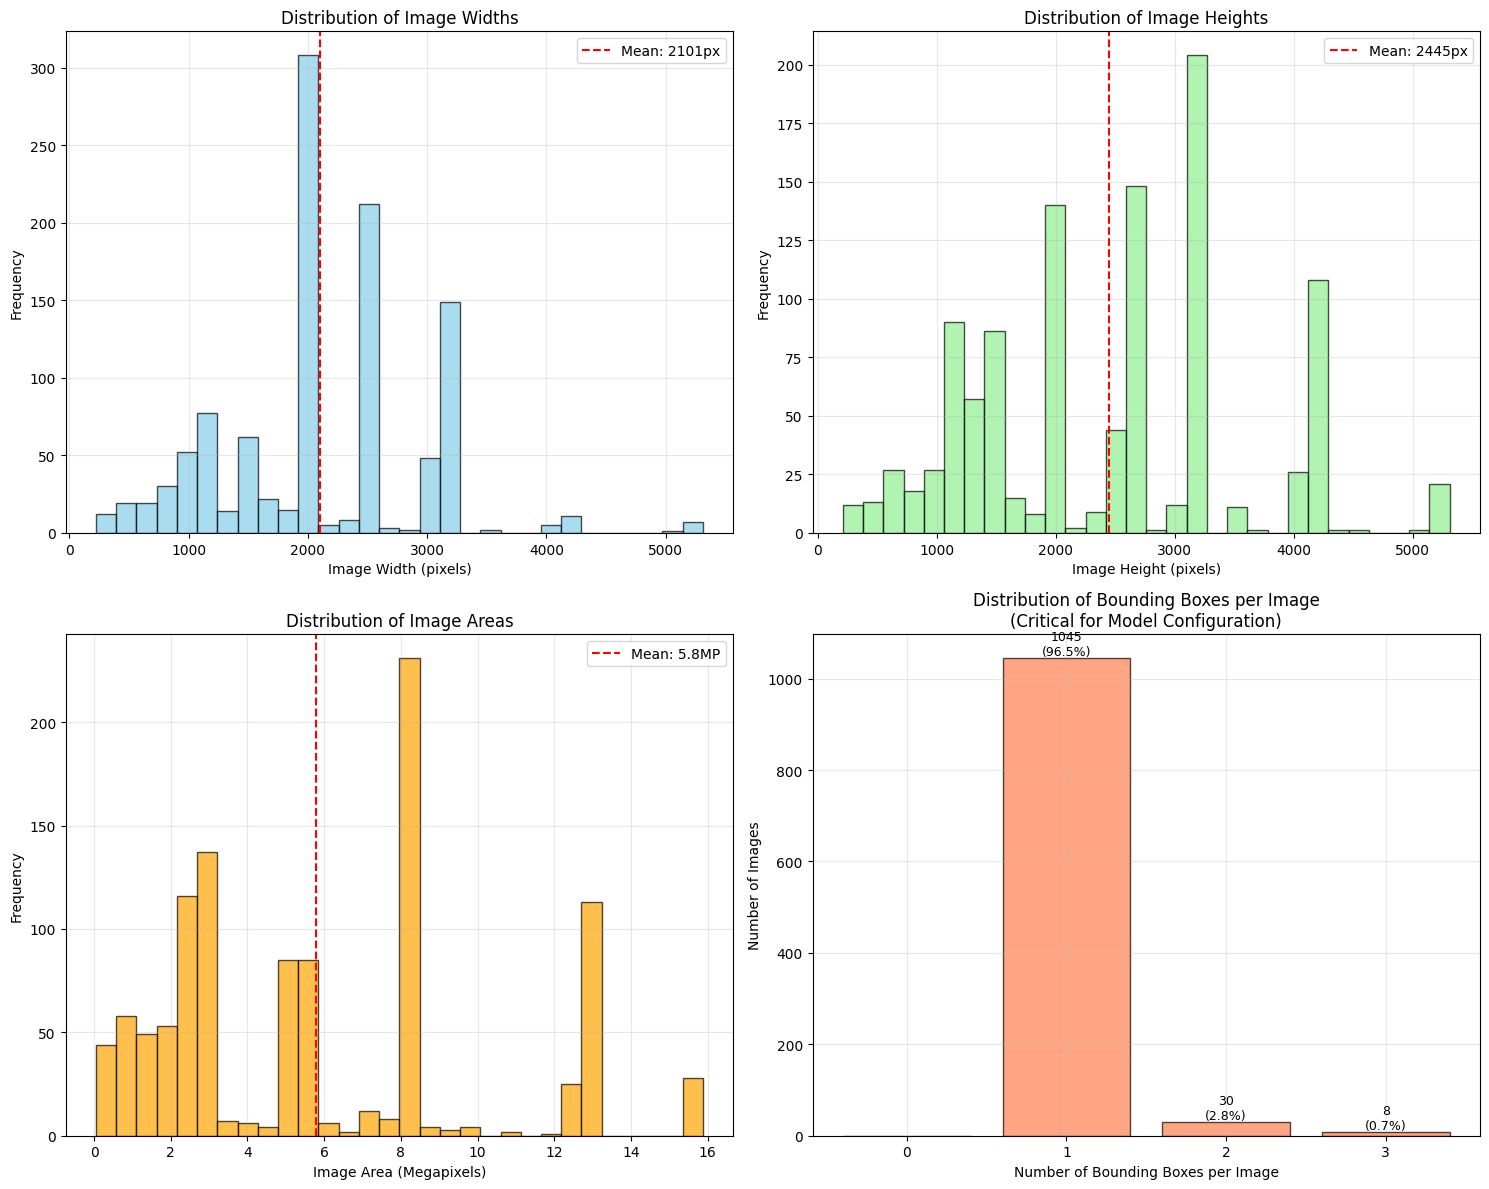


🔧 MODEL PREPARATION INSIGHTS:
  Most common image aspect ratio: 0.86 (width/height)

  Bounding box distribution breakdown:
    1 box(es): 1045 images ( 96.5%)
    2 box(es):  30 images (  2.8%)
    3 box(es):   8 images (  0.7%)

💡 RECOMMENDATIONS:
  ⚠️  Multi-object detection - configure model for up to 3 objects
  📐 Consider input resolution around 2404×2404 pixels
  🎯 Bounding box distribution is important for anchor/prior configuration


In [ ]:
# get the histogram of the image sizes
# get the histogram of the #bounding boxes per image - important for finetuning the model

# TASK: analyze dataset statistics for model preparation
print("=" * 60)
print("DATASET STATISTICS ANALYSIS")
print("=" * 60)
print("Analyzing image dimensions and bounding box distributions:")

import matplotlib.pyplot as plt
import numpy as np

# Collect statistics from all training examples
image_widths = []
image_heights = []
image_areas = []
num_bboxes_per_image = []

print(f"\nProcessing {len(train_dataset)} training examples...")

for idx, example in enumerate(train_dataset):
    # Get image dimensions
    width = example['width']
    height = example['height'] 
    area = width * height
    
    # Count bounding boxes in this image
    num_bboxes = len(example['objects']['bbox'])
    
    # Store statistics
    image_widths.append(width)
    image_heights.append(height)
    image_areas.append(area)
    num_bboxes_per_image.append(num_bboxes)

print(f"✅ Data collection complete!")

# Convert to numpy arrays for easier analysis
image_widths = np.array(image_widths)
image_heights = np.array(image_heights)
image_areas = np.array(image_areas)
num_bboxes_per_image = np.array(num_bboxes_per_image)

# Print summary statistics
print(f"\n📊 IMAGE DIMENSIONS SUMMARY:")
print(f"  Width  - Min: {image_widths.min():4d}px | Max: {image_widths.max():4d}px | Mean: {image_widths.mean():.1f}px")
print(f"  Height - Min: {image_heights.min():4d}px | Max: {image_heights.max():4d}px | Mean: {image_heights.mean():.1f}px")
print(f"  Area   - Min: {image_areas.min():8.0f} | Max: {image_areas.max():8.0f} | Mean: {image_areas.mean():.0f}")

print(f"\n🎯 BOUNDING BOXES SUMMARY:")
print(f"  Min boxes per image: {num_bboxes_per_image.min()}")
print(f"  Max boxes per image: {num_bboxes_per_image.max()}")
print(f"  Mean boxes per image: {num_bboxes_per_image.mean():.2f}")
print(f"  Total bounding boxes: {num_bboxes_per_image.sum()}")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Image widths histogram
_ = ax1.hist(image_widths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
_ = ax1.set_xlabel('Image Width (pixels)')
_ = ax1.set_ylabel('Frequency')
_ = ax1.set_title('Distribution of Image Widths')
_ = ax1.grid(True, alpha=0.3)
_ = ax1.axvline(image_widths.mean(), color='red', linestyle='--', label=f'Mean: {image_widths.mean():.0f}px')
_ = ax1.legend()

# 2. Image heights histogram  
_ = ax2.hist(image_heights, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
_ = ax2.set_xlabel('Image Height (pixels)')
_ = ax2.set_ylabel('Frequency')
_ = ax2.set_title('Distribution of Image Heights')
_ = ax2.grid(True, alpha=0.3)
_ = ax2.axvline(image_heights.mean(), color='red', linestyle='--', label=f'Mean: {image_heights.mean():.0f}px')
_ = ax2.legend()

# 3. Image areas histogram
_ = ax3.hist(image_areas/1e6, bins=30, alpha=0.7, color='orange', edgecolor='black')  # Convert to megapixels
_ = ax3.set_xlabel('Image Area (Megapixels)')
_ = ax3.set_ylabel('Frequency')
_ = ax3.set_title('Distribution of Image Areas')
_ = ax3.grid(True, alpha=0.3)
_ = ax3.axvline(image_areas.mean()/1e6, color='red', linestyle='--', label=f'Mean: {image_areas.mean()/1e6:.1f}MP')
_ = ax3.legend()

# 4. Number of bounding boxes histogram - CRITICAL FOR MODEL TUNING
bbox_counts = np.bincount(num_bboxes_per_image)
bbox_labels = np.arange(len(bbox_counts))
_ = ax4.bar(bbox_labels, bbox_counts, alpha=0.7, color='coral', edgecolor='black')
_ = ax4.set_xlabel('Number of Bounding Boxes per Image')
_ = ax4.set_ylabel('Number of Images')
_ = ax4.set_title('Distribution of Bounding Boxes per Image\n(Critical for Model Configuration)')
_ = ax4.grid(True, alpha=0.3)
_ = ax4.set_xticks(bbox_labels)

# Add percentage labels on bars
for i, count in enumerate(bbox_counts):
    if count > 0:
        percentage = (count / len(train_dataset)) * 100
        _ = ax4.text(i, count + 0.5, f'{count}\n({percentage:.1f}%)', 
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Additional insights for model preparation
print(f"\n🔧 MODEL PREPARATION INSIGHTS:")
print(f"  Most common image aspect ratio: {image_widths.mean()/image_heights.mean():.2f} (width/height)")

unique_bbox_counts, bbox_frequencies = np.unique(num_bboxes_per_image, return_counts=True)
print(f"\n  Bounding box distribution breakdown:")
for count, freq in zip(unique_bbox_counts, bbox_frequencies):
    percentage = (freq / len(train_dataset)) * 100
    print(f"    {count} box(es): {freq:3d} images ({percentage:5.1f}%)")

print(f"\n💡 RECOMMENDATIONS:")
if num_bboxes_per_image.max() == 1:
    print(f"  ✅ Single object detection - simpler model configuration")
else:
    print(f"  ⚠️  Multi-object detection - configure model for up to {num_bboxes_per_image.max()} objects")

print(f"  📐 Consider input resolution around {int(np.sqrt(image_areas.mean())):d}×{int(np.sqrt(image_areas.mean())):d} pixels")
print(f"  🎯 Bounding box distribution is important for anchor/prior configuration")

# For more dataset exploration, see notebooks/01_dataset_exploration.ipynb

# Understand Model

📓 **For detailed model exploration and testing, see:** [`notebooks/02_model_understanding.ipynb`](notebooks/02_model_understanding.ipynb)

This notebook covers:
- Tokenizer analysis and special tokens
- Model loading and configuration verification
- Complete inference pipeline demonstration
- Output parsing and visualization functions
- Pre-trained model testing on nutrition tables (single and multiple bounding boxes)

The sections below provide a streamlined version for the complete training pipeline.

You should read the Qwen2-VL paper to familiarize yourself with the following:

- **Model Architecture**
- **Data Processing**
- **Chat Template**

Next, review the model card and write an inference script for the model using Hugging Face.

Hugging Face provides an abstract API that simplifies usage by hiding many implementation details. While this is convenient, it may leave you with a superficial understanding of the model. To deepen your knowledge, explore the Qwen2-VL code and focus on these key aspects:

- **Understand the input format required by the model:**
  - Can you create an example input where the user provides two images and one video?

- **Explore `apply_chat_template`:**
  - Run this function on the example above and analyze the output. What does it do?

- **Understand `process_vision_info`:**
  - Review the code and determine what this function returns.

- **Examine `processor()`:**
  - Investigate its functionalities, such as:
    - Patch-ification
    - Replicating pad tokens
    - Text tokenization

- **[Optional] Analyze `model.generate()`'s [forward pass](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L999):**
  - Understand its operations, including:
    - Embedding image patches through `PatchEmbed`’s [forward pass](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L272).
    - Sending patch embeddings to a transformer for feature extraction:
      - Grasp the concept of 2D RoPE (Rotary Position Embedding).
      - Pay attention to [forbidden attention](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L339) when more than one image is provided.
    - Merging the resulting feature embeddings via [PatchMerger](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2_vl/modeling_qwen2_vl.py#L298).
    - Processing image and text embeddings using the LLM:
      - Pay special attention to multimodal RoPE.




In [ ]:
# TASK: write an inference function for qwen2-vl
import torch
import os
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import vision_process
from qwen_vl_utils import process_vision_info

def run_qwen2vl_inference(image_path_or_pil, prompt, model_id="Qwen/Qwen2-VL-7B-Instruct", device= "cuda" if torch.cuda.is_available() else "cpu"):
    """
    Run inference with Qwen2-VL model.
    
    Args:
        image_path_or_pil: Either a file path to an image or a PIL Image object
        prompt: Text prompt for the model
        model_id: Model identifier from HuggingFace
        device: Device to run inference on
    
    Returns:
        Generated text response from the model
    """
    # Load model and processor
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16, # original training precision stored in config.json for this model is bfloat16, so "auto" = torch.bfloat16 for this model
        attn_implementation="flash_attention_2",
        device_map=device
    )
    processor = Qwen2VLProcessor.from_pretrained(
        model_id,
        min_pixels=256*28*28,    # ~200k pixels (reduced from 3k default)
        max_pixels=1280*28*28,   # ~1M pixels (reduced from 12.8M default!)
        trust_remote_code=True
    ) # Or use AutoProcessor.from_pretrained(model_id), but in this case Qwen2VLProcessor is more explicit for demonstration purpose
    
    # Set model to evaluation mode for consistent inference
    model.eval()
    
    # Handle image input - can be path or PIL Image
    if isinstance(image_path_or_pil, str):
        from PIL import Image
        image = Image.open(image_path_or_pil)
    else:
        image = image_path_or_pil
    
    # Create the conversation format expected by Qwen2-VL
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image,
                },
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        }
    ]
    
    # Apply chat template to format the conversation
    text = processor.apply_chat_template(
        messages, 
        tokenize=False, #  if tokenize=True, the text will be tokenized and the tokens will be returned. if tokenize=False, the text will be returned as is.
        add_generation_prompt=True # adds assitant's token to the end of the text to prompts the model to generate response 
    )
    
    # Process vision information (handles image resizing, patching, etc.)
    image_inputs, video_inputs = process_vision_info(messages)
    
    # Prepare inputs for the model
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(device)
    
    # Generate response
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,  # Deterministic for object detection
        )
    
    # Decode only the generated tokens (excluding the input)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    
    return output_text

# Example usage (will be tested in next cell)
print("Inference function defined successfully!")

/home/zhuoyuan/miniconda3/envs/vlm_Qwen2VL_object_detection/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Inference function defined successfully!


Test your inference script using this [image](https://t4.ftcdn.net/jpg/01/57/82/05/360_F_157820583_agejYX5XeczPZuWRSCDF2YYeCGwJqUdG.jpg) with the prompt: “Detect the bounding box of the red car.” The model should correctly identify and locate the car in the image, confirming the script’s correctness.


📷 DISPLAYING ORIGINAL TEST IMAGE:


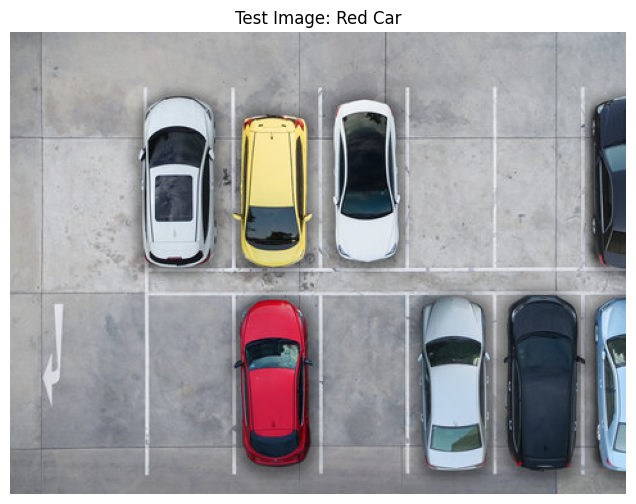


Testing Qwen2-VL inference...
Prompt: 'Detect the bounding box of the red car.'


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Model Response:
the red car(361,571),(491,935)

Expected output format(with skip_special_tokens=False): <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>
  Where coordinates are normalized to image dimensions (1000x1000 for Qwen2-VL)

Expected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)

Output now looks like expected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)


In [ ]:
# TASK: test the inference function
import requests
from PIL import Image
from io import BytesIO

# Download the test image (red car)
test_image_url = "https://t4.ftcdn.net/jpg/01/57/82/05/360_F_157820583_agejYX5XeczPZuWRSCDF2YYeCGwJqUdG.jpg"
response = requests.get(test_image_url)
test_image = Image.open(BytesIO(response.content))

# Display the test image
print("\n📷 DISPLAYING ORIGINAL TEST IMAGE:")
_ = plt.figure(figsize=(8, 6))
_ = plt.imshow(test_image)
_ = plt.title("Test Image: Red Car")
_ = plt.axis('off')
_ = plt.show()


# Test the inference function
print("\n" + "=" * 60)
print("Testing Qwen2-VL inference...")
print("Prompt: 'Detect the bounding box of the red car.'")


result = run_qwen2vl_inference(
    test_image, 
    "Detect the bounding box of the red car."
)
print("\nModel Response:")
print(result)

print("\n" + "=" * 60)

# For now, let's show what the expected output format should look like



print("Expected output format(with skip_special_tokens=False): <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>")
print("  Where coordinates are normalized to image dimensions (1000x1000 for Qwen2-VL)")
print("\nExpected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)")


print("\n" + "=" * 60)
print("Output now looks like expected output format(with skip_special_tokens=True): the red car(x1,y1),(x2,y2)")

# Try Qwen2VL without finetuning

📓 **For comprehensive pre-trained model testing with visualizations, see:** [`notebooks/02_model_understanding.ipynb`](notebooks/02_model_understanding.ipynb)

That notebook includes:
- Testing on single nutrition table examples
- Testing on examples with 2 bounding boxes
- Testing on examples with 3 bounding boxes
- Side-by-side comparisons of ground truth vs predictions

The sections below demonstrate the core functionality for this pipeline.

It's a good idea to first assess the model's current capability in detecting the nutrition table without any fine-tuning. This allows for a clear comparison between the model’s performance before and after fine-tuning. To do this, you need to write a function that extracts the bounding box by parsing the model output and then visualize the bounding box on the input image.

Notice that the model’s response will likely follow a different format than wat we saw above for the dog image. Why? One possible explanation is that the nutrition table does not belong to a previously object class seen during the model’s training phase. Additionally, the bounding box coordinates returned by the model are likely inaccurate. This should highlight the necessity of fine-tuning to improve the model’s performance.

In [ ]:
# TASK: write a function to parse model output to extract bounding box coordinates
import re

def parse_qwen_bbox_output(model_output):
    """
    Parse Qwen2-VL model output to extract bounding box coordinates.
    
    Args:
        model_output: String output from the model
        
    Returns:
        Dict with 'object' name and 'bbox' coordinates, or None if parsing fails

    Rationale: 
        I want to draw TWO pieces of information:
            1. WHAT was detected (object name) (Just in case if needed)
            2. WHERE it is (coordinates)
    """
    # Remove <|im_end|> token if present (appears when skip_special_tokens=False)
    model_output = model_output.replace('<|im_end|>', '').strip()
    
    # Pattern 1: WITH special tokens (skip_special_tokens=False)
    # Format: <|object_ref_start|>object name<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>
    pattern_with_tokens = r'<\|object_ref_start\|>(.+?)<\|object_ref_end\|><\|box_start\|>\((\d+),(\d+)\),\((\d+),(\d+)\)<\|box_end\|>'
    matches = re.findall(pattern_with_tokens, model_output)
    
    if matches:
        # Can handle multiple detections
        results = []
        for match in matches:
            object_name = match[0]
            x1, y1, x2, y2 = int(match[1]), int(match[2]), int(match[3]), int(match[4])
            results.append({
                'object': object_name,
                'bbox': [x1, y1, x2, y2]  # Qwen outputs in [x,y,x,y] format
            })
        return results[0] if len(results) == 1 else results
    
    # Pattern 2: WITHOUT special tokens (skip_special_tokens=True)
    # Format: "object name(x1,y1),(x2,y2)" - may have space before parenthesis
    pattern_no_tokens = r'([^\(]+?)\s*\((\d+),(\d+)\),\((\d+),(\d+)\)'
    matches = re.findall(pattern_no_tokens, model_output)
    
    if matches:
        # Can handle multiple detections
        results = []
        for match in matches:
            object_name = match[0].strip()
            x1, y1, x2, y2 = int(match[1]), int(match[2]), int(match[3]), int(match[4])
            results.append({
                'object': object_name,
                'bbox': [x1, y1, x2, y2]
            })
        return results[0] if len(results) == 1 else results
    
    return None  # No valid bbox found


# TASK: write a function to visualize the bounding boxes on the input image
def visualize_bbox_on_image(image, bbox_data, normalize_coords=True):
    """
    Visualize bounding boxes on an image.
    
    Args:
        image: PIL Image object
        bbox_data: Dict or list of dicts with 'object' and 'bbox' keys from parse_qwen_bbox_output
        normalize_coords: If True, bbox coords are in Qwen's [0,1000] space (from model output)
                         If False, bbox coords are already in pixel coordinates
        
    Returns:
        PIL Image with bounding boxes drawn and labeled with object names
    """
    from PIL import ImageDraw, ImageFont
    
    # Make a copy to avoid modifying original
    img_with_bbox = image.copy()
    draw = ImageDraw.Draw(img_with_bbox)
    width, height = img_with_bbox.size
    
    # Handle None case
    if bbox_data is None:
        print("No bounding box data to visualize")
        return img_with_bbox
    
    # Handle single or multiple bboxes
    if isinstance(bbox_data, dict):
        bbox_data = [bbox_data]
    
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
    
    for idx, data in enumerate(bbox_data):
        if data is None:
            continue
            
        color = colors[idx % len(colors)]
        bbox = data['bbox']
        object_name = data.get('object', 'unknown')
        
        # Convert coordinates if needed
        if normalize_coords:
            # Qwen uses 1000x1000 normalized space
            x1 = int(bbox[0] * width / 1000)
            y1 = int(bbox[1] * height / 1000)
            x2 = int(bbox[2] * width / 1000)
            y2 = int(bbox[3] * height / 1000)
        else:
            x1, y1, x2, y2 = bbox
        
        # Ensure coordinates are integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Draw rectangle with thicker line
        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)
        
        # Add label with background
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
        except:
            font = None
        
        label = f"{object_name}"
        if font:
            # Get text size for background
            bbox_label = draw.textbbox((x1, y1-30), label, font=font)
            # Draw background rectangle
            draw.rectangle(bbox_label, fill=color)
            # Draw text
            draw.text((x1, y1-30), label, fill='white', font=font)
        else:
            # Fallback without custom font
            draw.text((x1, y1-25), label, fill=color)
        
        print(f"Drew bbox in pixels for '{object_name}': [{x1}, {y1}, {x2}, {y2}]")
    
    return img_with_bbox

# Test the parsing function with the two expected formats
print("\n📝 Testing parse_qwen_bbox_output function:")
print("=" * 50)

# Test 1: WITH special tokens (skip_special_tokens=False)
test_with_tokens = "<|object_ref_start|>the red car<|object_ref_end|><|box_start|>(450,380),(650,520)<|box_end|><|im_end|>"
parsed1 = parse_qwen_bbox_output(test_with_tokens)
print(f"Test 1 - WITH special tokens (skip_special_tokens=False):")
print(f"  Input: {test_with_tokens}")
print(f"  Parsed: {parsed1}")
print(f"  ✅ Correctly extracts object='the red car' and bbox=[450,380,650,520]")

# Test 2: WITHOUT special tokens (skip_special_tokens=True)
test_no_tokens = "the red car(358,571),(492,943)"
parsed2 = parse_qwen_bbox_output(test_no_tokens)
print(f"\nTest 2 - WITHOUT special tokens (skip_special_tokens=True):")
print(f"  Input: {test_no_tokens}")
print(f"  Parsed: {parsed2}")
print(f"  ✅ Correctly extracts object='the red car' and bbox=[358,571,492,943]")

# Test 3: Real example from pre-trained model (nutrition table)
test_nutrition = "The nutrition table(13,60),(984,989) is located in the image"
parsed3 = parse_qwen_bbox_output(test_nutrition)
print(f"\nTest 3 - Real output from pre-trained model:")
print(f"  Input: {test_nutrition}")
print(f"  Parsed: {parsed3}")
if parsed3:
    print(f"  ✅ Successfully parsed even with extra text after coordinates")
else:
    print(f"  ❌ Failed to parse - check regex pattern")

print("=" * 50)


📝 Testing parse_qwen_bbox_output function:
Test 1 - WITH special tokens (skip_special_tokens=False):
  Input: <|object_ref_start|>the red car<|object_ref_end|><|box_start|>(450,380),(650,520)<|box_end|><|im_end|>
  Parsed: {'object': 'the red car', 'bbox': [450, 380, 650, 520]}
  ✅ Correctly extracts object='the red car' and bbox=[450,380,650,520]

Test 2 - WITHOUT special tokens (skip_special_tokens=True):
  Input: the red car(358,571),(492,943)
  Parsed: {'object': 'the red car', 'bbox': [358, 571, 492, 943]}
  ✅ Correctly extracts object='the red car' and bbox=[358,571,492,943]

Test 3 - Real output from pre-trained model:
  Input: The nutrition table(13,60),(984,989) is located in the image
  Parsed: {'object': 'The nutrition table', 'bbox': [13, 60, 984, 989]}
  ✅ Successfully parsed even with extra text after coordinates



VISUALIZING RED CAR DETECTION
Model output for red car: the red car(358,571),(492,943)
Parsed bbox: {'object': 'the red car', 'bbox': [358, 571, 492, 943]}
Drew bbox in pixels for 'the red car': [171, 205, 236, 339]


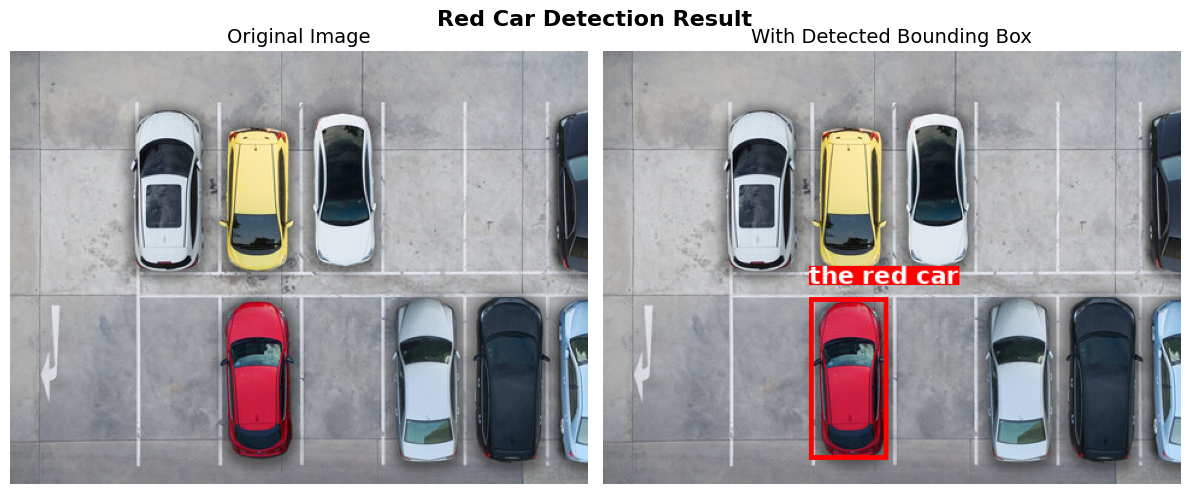

In [ ]:
# Now we want to look at where the bounding box is if we overlay the bounding box on the image
# First, let's visualize the red car detection that we already ran

import matplotlib.pyplot as plt

print("\n" + "=" * 60)
print("VISUALIZING RED CAR DETECTION")
print("=" * 60)

# We already have the result from earlier: "the red car(358,571),(492,943)"
red_car_output = "the red car(358,571),(492,943)"
print(f"Model output for red car: {red_car_output}")

# Parse the output
parsed_red_car = parse_qwen_bbox_output(red_car_output)
print(f"Parsed bbox: {parsed_red_car}")

if parsed_red_car:
    # Visualize the bbox on the red car image
    img_with_bbox = visualize_bbox_on_image(test_image, parsed_red_car, normalize_coords=True)
    
    # Display the result
    _ = plt.figure(figsize=(12, 5))
    
    # Original image
    _ = plt.subplot(1, 2, 1)
    _ = plt.imshow(test_image)
    _ = plt.title("Original Image", fontsize=14)
    _ = plt.axis('off')
    
    # Image with bounding box
    _ = plt.subplot(1, 2, 2)
    _ = plt.imshow(img_with_bbox)
    _ = plt.title("With Detected Bounding Box", fontsize=14)
    _ = plt.axis('off')
    
    _ = plt.suptitle("Red Car Detection Result", fontsize=16, fontweight='bold')
    _ = plt.tight_layout()
    _ = plt.show()


TESTING PRE-TRAINED MODEL ON NUTRITION TABLE

Using training example #0
Image size: (2592, 1944)
Ground truth: nutrition-table

Running inference...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model response: The nutrition table(10,45),(989,585) is located in the top left corner of the image, spanning from the top left to the bottom right.
Parsed bbox: {'object': 'The nutrition table', 'bbox': [10, 45, 989, 585]}
Drew bbox in pixels for 'The nutrition table': [25, 87, 2563, 1137]


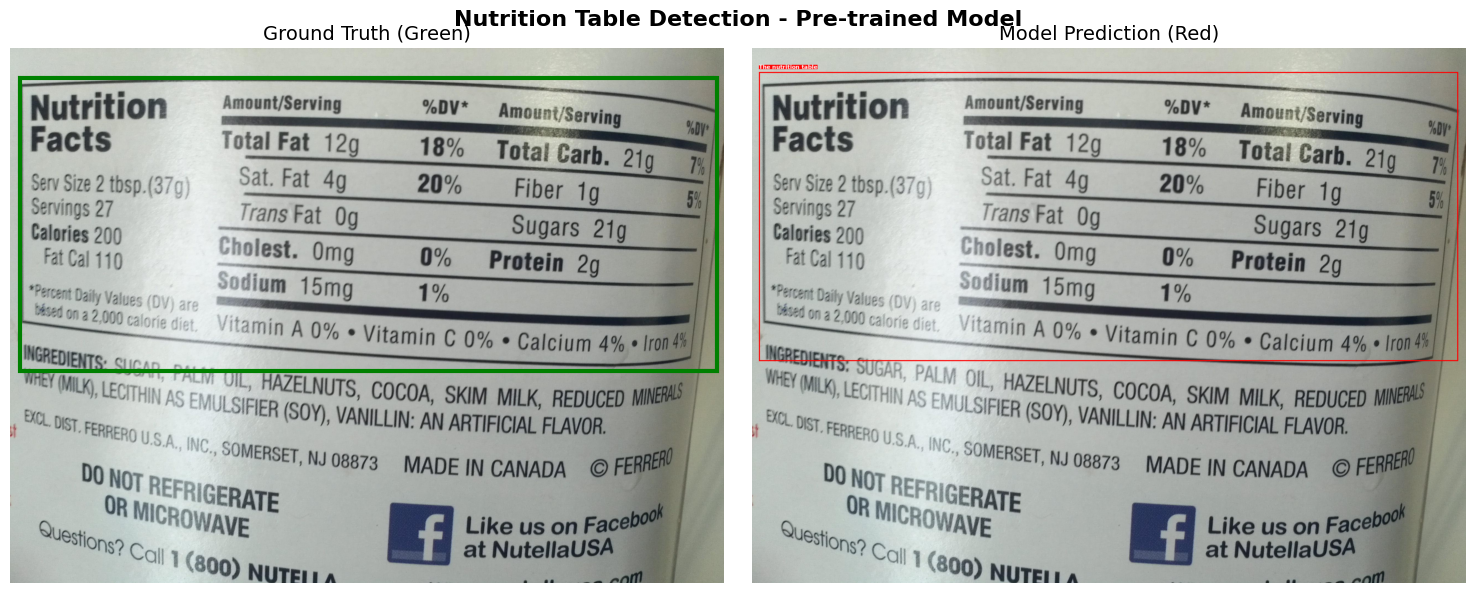

In [ ]:
# Now test the pre-trained model on a nutrition table image
print("\n" + "=" * 60)
print("TESTING PRE-TRAINED MODEL ON NUTRITION TABLE")
print("=" * 60)

# Get the first nutrition table example
example_idx = 0
example = train_dataset[example_idx]
nutrition_image = example['image']
ground_truth_bbox = example['objects']['bbox'][0]
ground_truth_category = example['objects']['category_name'][0]

print(f"\nUsing training example #{example_idx}")
print(f"Image size: {nutrition_image.size}")
print(f"Ground truth: {ground_truth_category}")

# Run inference
print("\nRunning inference...")
nutrition_response = run_qwen2vl_inference(
    nutrition_image,
    "Detect the bounding box of the nutrition table."
)
print(f"Model response: {nutrition_response}")

# Parse the output
parsed_nutrition = parse_qwen_bbox_output(nutrition_response)
print(f"Parsed bbox: {parsed_nutrition}")

# Visualize if parsing succeeded
if parsed_nutrition:
    # Create visualization
    img_with_nutrition_bbox = visualize_bbox_on_image(nutrition_image, parsed_nutrition, normalize_coords=True)
    
    # Show comparison
    _ = plt.figure(figsize=(15, 6))
    
    # Original with ground truth
    _ = plt.subplot(1, 2, 1)
    _ = plt.imshow(nutrition_image)
    
    # Draw ground truth rectangle
    # Use PIL image dimensions since we're drawing on the displayed image
    pil_width, pil_height = nutrition_image.size
    # CRITICAL: OpenFoodFacts uses [y_min, x_min, y_max, x_max] format
    y_min, x_min, y_max, x_max = ground_truth_bbox
    gt_x1 = int(x_min * pil_width)
    gt_y1 = int(y_min * pil_height)
    gt_x2 = int(x_max * pil_width)
    gt_y2 = int(y_max * pil_height)
    
    from matplotlib.patches import Rectangle
    ax = plt.gca()
    rect = Rectangle((gt_x1, gt_y1), gt_x2-gt_x1, gt_y2-gt_y1,
                     linewidth=3, edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    _ = plt.title("Ground Truth (Green)", fontsize=14)
    _ = plt.axis('off')
    
    # Model prediction
    _ = plt.subplot(1, 2, 2)
    _ = plt.imshow(img_with_nutrition_bbox)
    _ = plt.title("Model Prediction (Red)", fontsize=14)
    _ = plt.axis('off')
    
    _ = plt.suptitle("Nutrition Table Detection - Pre-trained Model", fontsize=16, fontweight='bold')
    _ = plt.tight_layout()
    _ = plt.show()
    

else:
    print("\nFailed to parse bbox - the model likely couldn't detect the nutrition table.")

## Note: for more detailed inference analysis and model understanding, please look at notebooks/02_model_understanding.ipynb.

# Data preprocessing


(Note: `notebooks/03_data_preprocessing.ipynb` has detailed documentation of data preprocessing, the following only keeps necessary parts. For detailed understanding of data preprocessing and the data pipeline, please look at `notebooks/03_data_preprocessing.ipynb`. It's very important for understanding how we handle None fields issue by dataset.map() later.)

The dataset requires conversion to be compatible with the Hugging Face (HF) library. Specifically, each sample must be reformatted into the OpenAI conversation format, comprising:

- Roles: system, user, and assistant
- User input: Provide an image and ask, "Detect the bounding box of the nutrition table."
- Assistant response: Format compatible with Qwen2-VL's detection question responses
    * See pages 7 and 43 of this [paper](https://arxiv.org/pdf/2409.12191) and  [Model Card](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct#more-usage-tips) for tips
    * Ensure inclusion of class name and bounding box coordinates using the proper special tokens.
    * Check the expected range of bb coordinates
    * Pay attention to the order of x,y coordinates as expected by Qwen

Here is an example system prompt:

In [ ]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from product images.
Your task is to analyze the provided product images and detect the nutrition tables in a certain format.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [ ]:
# Task: write a function to map each sample to a list of 3 dicts (one for each role)

def convert_to_conversation_format(example):
    """
    Convert a dataset example to Qwen2-VL conversation format.
    
    Why IMAGE_PLACEHOLDER?
    - HuggingFace dataset.map() needs serializable data (PIL images aren't)
    - The placeholder is replaced with the actual image during training (in collate_fn)
    - Image is stored separately at example['image'] to avoid duplication
    
    Coordinate Conversion:
    - Input: OpenFoodFacts [y_min, x_min, y_max, x_max] in [0,1]
    - Output: Qwen2-VL (x1,y1),(x2,y2) in [0,1000)
    
    Args:
        example: Dataset sample with 'image' and 'objects' fields
        
    Returns:
        Dict with 'messages' (conversation) and 'image' (PIL object)
    """
    # Validate input
    if 'objects' not in example or 'bbox' not in example['objects']:
        raise ValueError("Missing objects or bbox in example")
    
    # Extract nutrition table bounding boxes
    bboxes = example['objects']['bbox']
    categories = example['objects']['category_name']  # Fixed: 'category_name' not 'category'
    
    # Format the assistant response with Qwen2-VL special tokens
    # Convert normalized [0,1] bbox to Qwen's [0,1000) format
    assistant_responses = []
    for bbox, category in zip(bboxes, categories):
        # Validate bbox values are in [0,1] range (with small tolerance for rounding)
        if not all(-0.001 <= coord <= 1.001 for coord in bbox):
            print(f"Warning: bbox coordinates out of [0,1] range: {bbox}")
        
        # CRITICAL: OpenFoodFacts uses [y_min, x_min, y_max, x_max] format
        # But Qwen2VL expects (x_top_left, y_top_left), (x_bottom_right, y_bottom_right)
        y_min, x_min, y_max, x_max = bbox  # Unpack OpenFoodFacts format
        
        # Convert to Qwen format: (x,y) coordinates in [0,1000) range
        # Note: multiply by 1000 to convert from [0,1] to [0,1000)
        x1 = int(x_min * 1000)  # x_top_left
        y1 = int(y_min * 1000)  # y_top_left
        x2 = int(x_max * 1000)  # x_bottom_right
        y2 = int(y_max * 1000)  # y_bottom_right
        
        # Format: <|object_ref_start|>object<|object_ref_end|><|box_start|>(x1,y1),(x2,y2)<|box_end|>
        response = f"<|object_ref_start|>{category}<|object_ref_end|><|box_start|>({x1},{y1}),({x2},{y2})<|box_end|>"
        assistant_responses.append(response)
    
    # Combine multiple detections if present
    assistant_text = " ".join(assistant_responses)
    
    # Create conversation format WITHOUT the PIL image embedded
    conversation = [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ]
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": "IMAGE_PLACEHOLDER"  # Use placeholder instead of actual image
                },
                {
                    "type": "text",
                    "text": "Detect the bounding box of the nutrition table."
                }
            ]
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": assistant_text
                }
            ]
        }
    ]
    
    # Return messages and image separately
    return {
        "messages": conversation,
        "image": example['image']  # Store PIL image at top level
    }

Now, let's format the data using the chatbot structure. This will allow us to set up the interactions appropriately for our model.


In [ ]:
def _has_image(example):
    """
    Filter out samples with missing or invalid images.
    
    This function is crucial for preventing None values from leaking into
    process_vision_info during collation/training, which would cause crashes.
    
    Why this is necessary:
    - Some dataset samples may have corrupted or missing images
    - PIL Image loading can fail silently, leaving None values
    - The collate_fn and process_vision_info expect valid PIL images
    - Filtering ensures training stability and prevents runtime errors
    
    Args:
        example: Dataset sample that should contain an 'image' field
    
    Returns:
        bool: True if example has a valid PIL image with 'size' attribute
    """
    img = example.get('image')
    try:
        # Treat as valid only if it looks like a PIL image
        return (img is not None) and hasattr(img, 'size')
    except Exception:
        return img is not None

# Apply filtering before formatting
train_dataset = train_dataset.filter(_has_image)
eval_dataset = eval_dataset.filter(_has_image)


print(f"train_dataset[0]: {train_dataset[0]}")

# Task: apply the function above to all samples in the training and eval datasets
# Use remove_columns to get clean output with only 'messages' and 'image' fields
columns_to_remove = ['image_id', 'width', 'height', 'meta', 'objects']

# Unfortunately, HuggingFace datasets adds None fields during serialization of nested dicts
# This is a known behavior. We have two options:
# Option 1: Accept the None fields (they don't affect training, collate_fn handles them)
# Option 2: Post-process to remove them (adds overhead but cleaner)

# For now, using Option 1 - the collate_fn already handles None values correctly
train_dataset_formatted = train_dataset.map(
    convert_to_conversation_format,
    remove_columns=columns_to_remove
)
eval_dataset_formatted = eval_dataset.map(
    convert_to_conversation_format, 
    remove_columns=columns_to_remove
)

print(f"Formatted training samples: {len(train_dataset_formatted)}")
print(f"Formatted evaluation samples: {len(eval_dataset_formatted)}")

# NOTE: HuggingFace automatically adds 'image': None and 'text': None to content items
# This is expected behavior and the collate_fn handles it correctly

train_dataset[0]: {'image_id': '0009800892204_1', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x7F514DC017B0>, 'width': 2592, 'height': 1944, 'meta': {'barcode': '0009800892204', 'off_image_id': '1', 'image_url': 'https://static.openfoodfacts.org/images/products/000/980/089/2204/1.jpg'}, 'objects': {'bbox': [[0.057098764926195145, 0.014274691231548786, 0.603501558303833, 0.991126537322998]], 'category_id': [0], 'category_name': ['nutrition-table']}}
Formatted training samples: 1083
Formatted evaluation samples: 123


In [ ]:
# Inspect the first two elements of train_dataset_formatted (what actually goes to DataLoader)
print("\n" + "="*80)
print("INSPECTING train_dataset_formatted - ACTUAL DATASET PASSED TO TRAINER")
print("="*80)

# Simple inspection first
for i in range(2):
    print(f"\nSample {i}:")
    print(train_dataset_formatted[i])
    print("-" * 50)


INSPECTING train_dataset_formatted - ACTUAL DATASET PASSED TO TRAINER

Sample 0:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x7F515793F310>, 'messages': [{'content': [{'image': None, 'text': 'You are a Vision Language Model specialized in interpreting visual data from product images.\nYour task is to analyze the provided product images and detect the nutrition tables in a certain format.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.', 'type': 'text'}], 'role': 'system'}, {'content': [{'image': 'IMAGE_PLACEHOLDER', 'text': None, 'type': 'image'}, {'image': None, 'text': 'Detect the bounding box of the nutrition table.', 'type': 'text'}], 'role': 'user'}, {'content': [{'image': None, 'text': '<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(14,57),(991,603)<|box_end|>', 'type': 'text'}], 'role': 'assistant'}]}
---------------------------------

In [ ]:
# Display the same train_dataset_formatted samples with better formatting
from pprint import pprint

print("\n" + "="*60)
print("train_dataset_formatted[0] - Better formatted")
print("="*60)
print()
formatted_sample_0 = train_dataset_formatted[0]
pprint(formatted_sample_0)

print("\n" + "="*60)
print("train_dataset_formatted[1] - Better formatted")
print("="*60)
print()
formatted_sample_1 = train_dataset_formatted[1]
pprint(formatted_sample_1)


# Before we proceed with training the model in the next section, let's clear the current variables and clean the GPU to free up resources.


train_dataset_formatted[0] - Better formatted

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x7F515793F280>,
 'messages': [{'content': [{'image': None,
                            'text': 'You are a Vision Language Model '
                                    'specialized in interpreting visual data '
                                    'from product images.\n'
                                    'Your task is to analyze the provided '
                                    'product images and detect the nutrition '
                                    'tables in a certain format.\n'
                                    'Focus on delivering accurate, succinct '
                                    'answers based on the visual information. '
                                    'Avoid additional explanation unless '
                                    'absolutely necessary.',
                            'type': 'text'}],
               'role': 'system'},
      

## Step by Step data pipeline process (Deleted here to keep clean)

## (If you want to know more about the data processing pipeline within the data collators, please look at `notebooks/03_data_preprocessing.ipynb`)

That notebook documents:
- Step-by-step visualization of data transformations
- Sample outputs at each stage (before/after `dataset.map()`)
- The HuggingFace None fields issue explained with examples

**Key Discovery:** Our `convert_to_conversation_format()` function returns **clean** dicts like:
```python
{"type": "image", "image": "IMAGE_PLACEHOLDER"}
{"type": "text", "text": "Detect the bounding box..."}
```

But after `dataset.map()`, HuggingFace adds None fields for Apache Arrow schema consistency:
```python
{"type": "image", "image": "IMAGE_PLACEHOLDER", "text": None}  # <-- "text": None added!
{"type": "text", "text": "Detect the bounding box...", "image": None}  # <-- "image": None added!
```

This is **cosmetic only** - the collate_fn filters out None values during training.
See the notebook for full debugging walkthrough and visual examples.

In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.04 GB


In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Nov 26 03:58:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off |   00000000:01:00.0 Off |                  Off |
| 30%   37C    P2             55W /  300W |     559MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the Model for Training with NF4 weights  ⚙️

Next, you need to load the quantized model using [bitsandbytes](https://huggingface.co/docs/bitsandbytes/main/en/index). If you want to learn more about quantization, check out [this blog post](https://huggingface.co/blog/merve/quantization) or [this one](https://www.maartengrootendorst.com/blog/quantization/).


In [ ]:
# TASK: load the NF4 model and processor
from transformers import BitsAndBytesConfig, Qwen2VLForConditionalGeneration, Qwen2VLProcessor
import torch

# Configure 4-bit quantization for QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

model_id = "Qwen/Qwen2-VL-7B-Instruct"

# Load the model with 4-bit quantization
# Use "balanced" to evenly distribute model across available GPUs
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="balanced",  # Changed from "auto" to evenly distribute across GPUs
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",  # Use Flash Attention 2 for efficiency
    trust_remote_code=True,
)

# Load processor with optimized pixel configuration for faster training
processor = Qwen2VLProcessor.from_pretrained(
    model_id,
    min_pixels=256*28*28,    # ~200k pixels (reduced from 3k default)
    max_pixels=1280*28*28,   # ~1M pixels (reduced from 12.8M default!)
    trust_remote_code=True,
)

print(f"Model loaded: {model_id}")
print(f"Model device map: {model.hf_device_map}")
print(f"Model memory footprint: {model.get_memory_footprint() / 1024**3:.2f} GB")



Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model loaded: Qwen/Qwen2-VL-7B-Instruct
Model device map: {'model.visual': 0, 'model.language_model.embed_tokens': 0, 'model.language_model.layers.0': 0, 'model.language_model.layers.1': 0, 'model.language_model.layers.2': 0, 'model.language_model.layers.3': 0, 'model.language_model.layers.4': 0, 'model.language_model.layers.5': 0, 'model.language_model.layers.6': 1, 'model.language_model.layers.7': 1, 'model.language_model.layers.8': 1, 'model.language_model.layers.9': 1, 'model.language_model.layers.10': 1, 'model.language_model.layers.11': 1, 'model.language_model.layers.12': 1, 'model.language_model.layers.13': 1, 'model.language_model.layers.14': 1, 'model.language_model.layers.15': 1, 'model.language_model.layers.16': 1, 'model.language_model.layers.17': 1, 'model.language_model.layers.18': 1, 'model.language_model.layers.19': 1, 'model.language_model.layers.20': 1, 'model.language_model.layers.21': 1, 'model.language_model.layers.22': 1, 'model.language_model.layers.23': 1, 'mod

In [ ]:
# IMPORTANT: For TRL version 0.12.0, we need to manually prepare the model before LoRA
# Newer versions (0.21+) do this automatically, but 0.12.0 does not
from peft import prepare_model_for_kbit_training

# Define the trainable parameter summarizer function first (before using it)
def _summarize_trainables(model_to_summarize):
    try:
        total_params, trainable_params = 0, 0
        trainable_examples = []
        for param_name, param_tensor in model_to_summarize.named_parameters():
            param_count = param_tensor.numel()
            total_params += param_count
            if param_tensor.requires_grad:
                trainable_params += param_count
                if len(trainable_examples) < 8:
                    device_str = str(param_tensor.device)
                    trainable_examples.append(f"- {param_name} | shape={tuple(param_tensor.shape)} | device={device_str}")
        trainable_percentage = 100.0 * trainable_params / max(total_params, 1)
        print("\nTrainable parameter summary:")
        print(f"  Total params: {total_params:,}")
        print(f"  Trainable params: {trainable_params:,} ({trainable_percentage:.2f}%)")
        if hasattr(model_to_summarize, 'hf_device_map'):
            print("  Device map snapshot (first 10):")
            device_count = 0
            for module_name, device_location in model_to_summarize.hf_device_map.items():
                print(f"    {module_name} -> {device_location}")
                device_count += 1
                if device_count >= 10:
                    break
        if trainable_examples:
            print("  Sample trainable tensors:")
            for example in trainable_examples:
                print("    ", example)
    except Exception as error:
        print(f"[warn] could not summarize trainables: {error}")

# =============================================================================
# COMMENTED OUT: Manual prepare_model_for_kbit_training
#
# BUG FIX (2025-11-25): SFTTrainer internally calls prepare_model_for_kbit_training
# when it detects QLoRA (see trl/models/utils.py:prepare_peft_model lines 23-29).
# If we call it manually AND pass a PeftModel to SFTTrainer, SFTTrainer calls it
# AGAIN on the PeftModel, which freezes ALL parameters including LoRA (trainable=0).
#
# Solution: Let SFTTrainer handle this by passing peft_config instead of
# manually creating a PeftModel.
#
# See: https://github.com/huggingface/trl/issues/3926
# =============================================================================
# print("=== Before prepare_model_for_kbit_training ===")
# _summarize_trainables(model)
# model = prepare_model_for_kbit_training(model)
# print("\n✅ Model prepared for k-bit training")
# print("\n=== After prepare_model_for_kbit_training ===")
# _summarize_trainables(model)

## Set Up QLoRA and SFTConfig 🚀

Next, you need to configure [QLoRA](https://github.com/artidoro/qlora) for your training setup. QLoRA enables efficient fine-tuning of large language models while significantly reducing the memory footprint compared to traditional methods. Unlike standard LoRA, which reduces memory usage by applying a low-rank approximation, QLoRA takes it a step further by quantizing the model weights. This leads to even lower memory requirements and improved training efficiency, making it an excellent choice for optimizing our model's performance without sacrificing quality.

💡 NOTE:

Preparing a model for QLoRA training typically involves three key steps:

- Load the base model in 4-bit (using BitsAndBytesConfig).

- Run prepare_model_for_kbit_training(). 🚨 Understand what this function does.

- Apply LoRA adapters to the target modules.

You can perform these steps manually, or let SFTTrainer handle steps 2 & 3 for you:

- Simply load the model in 4-bit,

- Pass a peft_config to SFTTrainer, which will automatically run prepare_model_for_kbit_training() (for unsharded QLoRA) and attach LoRA adapters. See lines 610 and 625 in [here](https://github.com/huggingface/trl/blob/v0.21.0/trl/trainer/sft_trainer.py)





In [ ]:
from peft import LoraConfig, get_peft_model
# Task: create LoRA config and apply LoRA to the model instrance created above

# Configure LoRA
lora_config = LoraConfig(
    r=64,  # Rank
    lora_alpha=128,  # Alpha scaling
    lora_dropout=0.1,  # Dropout probability
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
        "gate_proj", "up_proj", "down_proj",  # MLP layers
    ],
)

print("LoRA Configuration:")
print(f"  Rank (r): {lora_config.r}")
print(f"  Alpha: {lora_config.lora_alpha}")
print(f"  Dropout: {lora_config.lora_dropout}")
print(f"  Target modules: {lora_config.target_modules}")

# =============================================================================
# COMMENTED OUT: Manual get_peft_model
#
# BUG FIX (2025-11-25): Same issue as prepare_model_for_kbit_training above.
# SFTTrainer will call get_peft_model internally when we pass peft_config.
# If we call it manually, SFTTrainer's prepare_peft_model will call
# prepare_model_for_kbit_training on our PeftModel, freezing all params.
#
# Solution: Pass lora_config to SFTTrainer via peft_config parameter instead.
# =============================================================================
# model = get_peft_model(model, lora_config)
# print("\n✅ LoRA adapters attached to model")
# print("\n=== PEFT's parameter count (includes full base model) ===")
# model.print_trainable_parameters()
# print("\n=== After get_peft_model (LoRA attached) - Custom count ===")
# _summarize_trainables(model)

print("\n✅ LoRA config created (will be applied by SFTTrainer)")
print("   Note: We pass peft_config to SFTTrainer instead of manually calling get_peft_model")

LoRA Configuration:
  Rank (r): 64
  Alpha: 128
  Dropout: 0.1
  Target modules: {'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'up_proj', 'q_proj', 'down_proj'}

✅ LoRA config created (will be applied by SFTTrainer)
   Note: We pass peft_config to SFTTrainer instead of manually calling get_peft_model


Next, you need to create an SFT config for model finetuning. This step is critical for model convergence.
You should set the following hyper-parameteres among others:
 - learning_rate
 - per_device_train_batch_size
 - gradient_accumulation_steps for better gradient direction estimation
 - BF16 and TF32 enablement for memory saving and faster compute
 - gradient_checkpointing for memory saving
   
There are other input arguments that you should also set for proper evaluation during model finetuning.

In [ ]:
from trl import SFTConfig
# TASK: create an SFT config

training_args = SFTConfig(
    # Output and logging - SAVE TO SSD TO AVOID HOME DIRECTORY QUOTA
    output_dir="/ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora",
    logging_dir="/ssd1/zhuoyuan/vlm_outputs/logs",
    logging_steps=10,  # Show training loss every 10 steps for frequent updates
    
    # Training hyperparameters
    num_train_epochs=3,
    per_device_train_batch_size=1,  # Adjust based on GPU memory
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,  # Back to 8 for larger effective batch size (2 * 1 * 8 = 16)
    gradient_checkpointing=False,  # Disabled - causes issues with QLoRA
    # gradient_checkpointing_kwargs={"use_reentrant": False},  # Not needed when disabled
    
    # Learning rate and optimization
    learning_rate=2e-5,  # Slightly higher for better convergence with vision models
    warmup_steps=100,
    lr_scheduler_type="cosine",
    optim="adamw_torch",
    adam_beta2=0.999,
    weight_decay=0.01,
    max_grad_norm=1.0,
    
    # Mixed precision and performance
    bf16=True,  # Use bfloat16 precision
    tf32=True,  # Enable TF32 on Ampere GPUs
    dataloader_num_workers=0,
    # dataloader_num_workers=2,  # Use 2 workers for better data loading
    # dataloader_pin_memory=True,  # Pin memory for faster GPU transfer
    
    # Evaluation and saving
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=300,  # Changed from 100 to 300 - fewer checkpoints
    save_total_limit=3,  # Only keep last 3 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    
    # Other settings
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="wandb",  # Use W&B for logging metrics (changed from tensorboard)
    run_name="qwen2vl-nutrition-detection",
    seed=42,  # For reproducibility
    
    # Specific for vision models
    dataset_text_field="",  # Empty string because we use custom data_collator, not "messages"
    # Note: dataset_text_field would be "messages" if we wanted SFTTrainer to handle text extraction,
    # but we handle everything in our custom collate_fn, so we leave it empty
    max_length=2048,
    dataset_kwargs={
        "skip_prepare_dataset": True  # We handle data preparation ourselves
    },
)

print("Training Configuration:")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size per device: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation steps: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Number of epochs: {training_args.num_train_epochs}")
print(f"  Random seed: {training_args.seed}")

Training Configuration:
  Learning rate: 2e-05
  Batch size per device: 1
  Gradient accumulation steps: 8
  Effective batch size: 8
  Number of epochs: 3
  Random seed: 42


# wandb setup
If you have wandb account, you can set it up here.
Let’s connect our notebook to W&B to capture essential information during training.
Make sure to have set the logging arguments in the SFT config.


In [ ]:
# Initialize W&B for experiment tracking
import wandb

wandb.login()  # reads the key from the env

# Initialize Weights & Biases for experiment tracking
wandb.init(
    project="qwen2vl-nutrition-detection",
    name="qwen2vl-7b-nutrition-lora",
    config={
        "model": model_id,
        "lora_r": lora_config.r,
        "lora_alpha": lora_config.lora_alpha,
        "learning_rate": training_args.learning_rate,
        "batch_size": training_args.per_device_train_batch_size,
        "gradient_accumulation": training_args.gradient_accumulation_steps,
        "epochs": training_args.num_train_epochs,
        "dataset": "openfoodfacts/nutrition-table-detection",
    },
    tags=["qwen2-vl", "object-detection", "nutrition-table", "lora"],
)

print("✅ W&B initialized for experiment tracking")
print(f"View your run at: {wandb.run.get_url()}")

wandb: Currently logged in as: zhuoyuan-jiang-yale (zhuoyuan-jiang-yale-yale-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


✅ W&B initialized for experiment tracking
View your run at: https://wandb.ai/zhuoyuan-jiang-yale-yale-university/qwen2vl-nutrition-detection/runs/zljkh57t


## Training the Model 🏃

You should now create a trainer object by instantiating the SFTTrainer class of HF's TRL. For this, you need to provide the training dataset, model, tokenizer, and more important a collate function.

You need a collator function to properly retrieve and batch the data during the training procedure. This function will receive as the input a batch of samples:

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from product images.\nYour task is to analyze the provided product images and detect the nutrition tables in a certain format. \nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944>},
   {'type': 'text',
    'text': 'Detect the bounding box of the nutrition table'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': '<|object_ref_start|>the nutrition table<|object_ref_end|><|box_start|>(14,57),(991,604)<|box_end|>'}]}]
    
[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from product images.\nYour task is to analyze the provided product images and detect the nutrition tables in a certain format. \nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=306x408>},
   {'type': 'text',
    'text': 'Detect the bounding box of the nutrition table'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': '<|object_ref_start|>the nutrition table<|object_ref_end|><|box_start|>(147,152),(516,588)<|box_end|>'}]}]

and then performs ops similar to what we did earlier in the inference script:
  - applying chat template on each sample in the batch -> get formatted prompt
  - applying process_vision_info on each sample in the batch -> get image pixels
  - applying processor on formatted prompt and image pixels -> new batch
  - modify the labels of the new batch by replacing labels correspondings to the following items to -100 (why?)
    * text pad tokens
    * <|vision_start|> <|vision_end|> <|image_pad|>

👉 Check out the TRL official example [scripts]( https://github.com/huggingface/trl/blob/main/examples/scripts/sft_vlm.py#L87) for more details.


## Data Collator Function

The collator function is critical for properly batching text-image pairs during training.
It handles the conversion from our formatted dataset to the format expected by the model.

In [ ]:
import torch 
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
# Fixed collate_fn with improved error handling and robust masking  
class collate_fn_fixed_1:
    """
    FIXED VERSION: Robust collate function that prevents out-of-range label issues.
    
    This collator:
    1. Restores IMAGE_PLACEHOLDER with actual PIL images
    2. Uses process_vision_info to properly extract and format images
    3. Applies chat template to get formatted text
    4. Tokenizes text and processes images together
    5. Creates labels with proper masking for loss computation
    
    Key improvements:
    - Properly masks all vision/special tokens to prevent training on them
    - Validates that no out-of-vocabulary tokens exist in labels
    - Uses token-based span finding for robust assistant response extraction
    - Handles edge cases gracefully (samples without images, OOV tokens)
    
    Args:
        batch: List of samples from the dataset, each containing 'messages' and 'image'
        
    Returns:
        Dict with input_ids, attention_mask, pixel_values, image_grid_thw, and labels
    """

    # set mask for the following tokens:     
    # * text pad tokens
    # * <|vision_start|> <|vision_end|> <|image_pad|>
    def __init__(self, processor, model):
        self.processor = processor
        self.model = model
        self.masked_token_ids = [
            self.processor.tokenizer.pad_token_id,  # This one exists as attribute
            self.processor.tokenizer.convert_tokens_to_ids('<|vision_start|>'),
            self.processor.tokenizer.convert_tokens_to_ids('<|vision_end|>'),
            self.processor.tokenizer.convert_tokens_to_ids('<|image_pad|>')
        ]

    def __call__(self, batch):  

        # STEP 1: Format the dataset into desired format:
        # Restores IMAGE_PLACEHOLDER with actual PIL image
        # so each element in the batch looks like sample of convert_to_conversation_format(train_dataset[0])

        # Extract messages and images from each sample
        messages_list = [sample['messages'] for sample in batch]
        images_list = [sample.get('image', None) for sample in batch]

        # Filter out samples without images
        valid_pairs = [(m, img) for m, img in zip(messages_list, images_list) if img is not None]
        if not valid_pairs:
            raise ValueError("Batch contains no valid images.")

        messages_list, images_list = zip(*valid_pairs)
        messages_list = list(messages_list)
        images_list = list(images_list)


        all_conversations = []  # This will hold complete conversations, each conversation is a list of 3 messages (system, assistant, user)

        for messages, image in zip(messages_list, images_list):
            messages_with_image = []
            # Clean up messages: remove None values and restore images
            for msg in messages:
                msg_copy = {'role': msg['role'], 'content': []}
                
                for content_item in msg['content']:
                    # Skip None entries entirely
                    if content_item is None:
                        continue
                        
                    # Process text content - filter out None text values
                    if content_item.get('type') == 'text':
                        text_value = content_item.get('text')
                        if text_value is not None and text_value != 'None':  # Check for actual None and string 'None'
                            msg_copy['content'].append({
                                'type': 'text',
                                'text': text_value
                            })
                    # Process image content - replace IMAGE_PLACEHOLDER with actual PIL image
                    elif content_item.get('type') == 'image' and msg['role'] == 'user':
                        # Check if it's IMAGE_PLACEHOLDER and replace with actual image
                        image_value = content_item.get('image')
                        if image_value == 'IMAGE_PLACEHOLDER' or image_value is None:
                            # Replace with the actual PIL image from top level
                            msg_copy['content'].append({
                                'type': 'image',
                                'image': image  # Use the actual PIL image
                            })
                        elif image_value and image_value != 'None':
                            # Use existing image if it's not placeholder
                            msg_copy['content'].append({
                                'type': 'image',
                                'image': image_value
                            })
                
                if msg_copy['content']:
                    messages_with_image.append(msg_copy)

            # Add the complete conversation (3 messages) to collection
            all_conversations.append(messages_with_image)
        
        # Apply chat template to get text
        text = self.processor.apply_chat_template(
            all_conversations,
            tokenize=False,
            add_generation_prompt=False
        )

        # process_vision_info to get image and video
        image, video = process_vision_info(all_conversations)

        # Process texts and images together
        batch_inputs = self.processor( # batch_inputs is a dictionary containing input_ids, attention_mask, pixel_values, and image_grid_thw
            text=text,
            images=image,
            # videos=video,
            padding=True,
            truncation=False,
            return_tensors="pt"
        )
 


        # if 'input_ids' in batch_inputs: # only this fixes torch_dtype=torch.int32 error
        #     batch_inputs['input_ids'] = batch_inputs['input_ids'].to(torch.long)
        # if 'image_grid_thw' in batch_inputs:
        #     batch_inputs['image_grid_thw'] = batch_inputs['image_grid_thw'].to(torch.int32)
        # if 'pixel_values' in batch_inputs:
        #     batch_inputs['pixel_values'] = batch_inputs['pixel_values'].to(torch.int32)


        # Create labels from input_ids
        labels = batch_inputs["input_ids"].clone()
        for token_id in self.masked_token_ids:
            labels[labels == token_id] = -100
        batch_inputs["labels"] = labels

        # # FIX: Convert all int64 tensors to int32 for Flash Attention
        # for key, value in batch_inputs.items():
        #     if torch.is_tensor(value) and value.dtype == torch.int64:
        #         batch_inputs[key] = value.to(torch.int32)

        # print(batch_inputs) #  for debugging, uncomment

        return batch_inputs

print("✅ Fixed collate_fn_1 created")

✅ Fixed collate_fn_1 created


In [ ]:
# Fixed collate_fn with Flash Attention dtype fix for cu_seqlens
class collate_fn_fixed_fixed1:
    """
    FIXED VERSION 2: Fixes Flash Attention cu_seqlens_q dtype error.
    
    The error "RuntimeError: cu_seqlens_q must have dtype int32" occurs because
    Flash Attention expects cumulative sequence length tensors to be int32,
    but they're created as int64 internally.
    
    This collator patches the Flash Attention forward pass to ensure cu_seqlens
    tensors have the correct dtype.
    """
    
    def __init__(self, processor, model):
        self.processor = processor
        self.model = model
        self.masked_token_ids = [
            self.processor.tokenizer.pad_token_id,
            self.processor.tokenizer.convert_tokens_to_ids('<|vision_start|>'),
            self.processor.tokenizer.convert_tokens_to_ids('<|vision_end|>'),
            self.processor.tokenizer.convert_tokens_to_ids('<|image_pad|>')
        ]
        self.call_count = 0  # Track calls to limit debug output
        
        # Apply monkey patch to fix cu_seqlens dtype issue
        self._patch_flash_attention()
    
    def _patch_flash_attention(self):
        """Monkey-patch Flash Attention to fix cu_seqlens dtype."""
        import flash_attn.flash_attn_interface as flash_interface
        
        # Store original _flash_attn_varlen_forward function
        original_flash_varlen_forward = flash_interface._flash_attn_varlen_forward
        
        def patched_flash_varlen_forward(q, k, v, cu_seqlens_q, cu_seqlens_k, 
                                        max_seqlen_q, max_seqlen_k, *args, **kwargs):
            # Convert cu_seqlens to int32 if needed
            if cu_seqlens_q is not None and cu_seqlens_q.dtype != torch.int32:
                cu_seqlens_q = cu_seqlens_q.to(torch.int32)
            if cu_seqlens_k is not None and cu_seqlens_k.dtype != torch.int32:
                cu_seqlens_k = cu_seqlens_k.to(torch.int32)
            
            # Call original function with fixed dtypes
            return original_flash_varlen_forward(q, k, v, cu_seqlens_q, cu_seqlens_k,
                                                max_seqlen_q, max_seqlen_k, *args, **kwargs)
        
        # Replace the internal _flash_attn_varlen_forward function
        flash_interface._flash_attn_varlen_forward = patched_flash_varlen_forward
        
        # Also patch the FlashAttnVarlenFunc.forward method
        from flash_attn.flash_attn_interface import FlashAttnVarlenFunc
        original_forward = FlashAttnVarlenFunc.forward
        
        @staticmethod
        def patched_forward(ctx, q, k, v, cu_seqlens_q, cu_seqlens_k, 
                          max_seqlen_q, max_seqlen_k, *args):
            # Convert cu_seqlens to int32 if needed
            if cu_seqlens_q is not None and cu_seqlens_q.dtype != torch.int32:
                cu_seqlens_q = cu_seqlens_q.to(torch.int32)
            if cu_seqlens_k is not None and cu_seqlens_k.dtype != torch.int32:
                cu_seqlens_k = cu_seqlens_k.to(torch.int32)
            
            # Call original forward with fixed dtypes
            return original_forward(ctx, q, k, v, cu_seqlens_q, cu_seqlens_k,
                                   max_seqlen_q, max_seqlen_k, *args)
        
        FlashAttnVarlenFunc.forward = patched_forward
        print("✅ Applied Flash Attention cu_seqlens dtype patch (both _flash_attn_varlen_forward and FlashAttnVarlenFunc.forward)")
    
    def __call__(self, batch):
        # Extract messages and images from each sample
        messages_list = [sample['messages'] for sample in batch]
        images_list = [sample.get('image', None) for sample in batch]
        
        # Filter out samples without images
        valid_pairs = [(m, img) for m, img in zip(messages_list, images_list) if img is not None]
        if not valid_pairs:
            raise ValueError("Batch contains no valid images.")
        
        messages_list, images_list = zip(*valid_pairs)
        messages_list = list(messages_list)
        images_list = list(images_list)
        
        all_conversations = []
        
        for messages, image in zip(messages_list, images_list):
            messages_with_image = []
            for msg in messages:
                msg_copy = {'role': msg['role'], 'content': []}
                
                for content_item in msg['content']:
                    if content_item is None:
                        continue
                    
                    if content_item.get('type') == 'text':
                        text_value = content_item.get('text')
                        if text_value is not None and text_value != 'None':
                            msg_copy['content'].append({
                                'type': 'text',
                                'text': text_value
                            })
                    elif content_item.get('type') == 'image' and msg['role'] == 'user':
                        image_value = content_item.get('image')
                        if image_value == 'IMAGE_PLACEHOLDER' or image_value is None:
                            msg_copy['content'].append({
                                'type': 'image',
                                'image': image
                            })
                        elif image_value and image_value != 'None':
                            msg_copy['content'].append({
                                'type': 'image',
                                'image': image_value
                            })
                
                if msg_copy['content']:
                    messages_with_image.append(msg_copy)
            
            all_conversations.append(messages_with_image)
        
        # Apply chat template
        text = self.processor.apply_chat_template(
            all_conversations,
            tokenize=False,
            add_generation_prompt=False
        )
        
        # Process vision info
        image, video = process_vision_info(all_conversations)
        
        # Process texts and images together
        batch_inputs = self.processor(
            text=text,
            images=image,
            padding=True,
            truncation=False,
            return_tensors="pt"
        )
        
        # Ensure correct dtypes for all tensors
        if 'input_ids' in batch_inputs:
            batch_inputs['input_ids'] = batch_inputs['input_ids'].to(torch.long)
        
        if 'attention_mask' in batch_inputs:
            batch_inputs['attention_mask'] = batch_inputs['attention_mask'].to(torch.long)
        
        # Create labels with masking
        labels = batch_inputs["input_ids"].clone()
        for token_id in self.masked_token_ids:
            labels[labels == token_id] = -100
        batch_inputs["labels"] = labels
        
        # Debug output disabled for clean training logs
        # Uncomment the lines below if you need to debug token masking:
        # self.call_count += 1
        # if self.call_count <= 3:  # Only show first 3 samples
        #     non_masked = (labels != -100).sum().item()
        #     total = labels.numel()
        #     if non_masked > 0 and total > 0:
        #         print(f"[Sample {self.call_count}] Training on {non_masked}/{total} tokens ({100*non_masked/total:.1f}%)")
        
        return batch_inputs

print("✅ Fixed collate_fn_fixed_fixed1 created with Flash Attention dtype patch")

✅ Fixed collate_fn_fixed_fixed1 created with Flash Attention dtype patch


In [ ]:
# Use the already loaded model and processor from above
collate_fn = collate_fn_fixed_1(processor, model)

In [ ]:
# Function to analyze token distribution
def analyze_token_distribution(collate_fn, dataset, num_samples=3):
    """
    Analyze what tokens are being trained on vs masked.
    This helps understand why loss might not be decreasing.
    """
    print("\n" + "="*60)
    print("TOKEN DISTRIBUTION ANALYSIS")
    print("="*60)
    print(f"Analyzing {num_samples} samples to understand training tokens...\n")
    
    for i in range(min(num_samples, len(dataset))):
        test_batch = [dataset[i]]
        batch_output = collate_fn(test_batch)
        
        input_ids = batch_output['input_ids'][0]
        labels = batch_output['labels'][0]
        
        # Count token types
        total_tokens = len(input_ids)
        masked_tokens = (labels == -100).sum().item()
        trained_tokens = total_tokens - masked_tokens
        
        print(f"Sample {i+1}:")
        print(f"  Total tokens: {total_tokens}")
        print(f"  Masked (ignored): {masked_tokens} tokens")
        print(f"  Trained on: {trained_tokens} tokens ({100*trained_tokens/total_tokens:.1f}%)")
        
        # Decode what we're training on
        trained_indices = (labels != -100).nonzero(as_tuple=True)[0]
        if len(trained_indices) > 0:
            # Show first and last parts of what we're training on
            trained_token_ids = input_ids[trained_indices]
            decoded = processor.tokenizer.decode(trained_token_ids, skip_special_tokens=False)
            
            # # Clean up for display
            # decoded_clean = decoded.replace('<|im_start|>', '[START]')
            # decoded_clean = decoded_clean.replace('<|im_end|>', '[END]')
            # decoded_clean = decoded_clean.replace('<|object_ref_start|>', '[OBJ]')
            # decoded_clean = decoded_clean.replace('<|object_ref_end|>', '[/OBJ]')
            # decoded_clean = decoded_clean.replace('<|box_start|>', '[BOX]')
            # decoded_clean = decoded_clean.replace('<|box_end|>', '[/BOX]')
            
            # if len(decoded_clean) > 150:
            #     print(f"  Training content: '{decoded_clean[:75]}...{decoded_clean[-75:]}'")
            # else:
            #     print(f"  Training content: '{decoded_clean}'")
            print(decoded)
        
        print()
    
    print("📊 BREAKDOWN OF TRAINED TOKENS:")
    print("  ~50 tokens: System prompt (static - same every sample)")
    print("  ~10 tokens: User prompt 'Detect the bounding box...' (static)")
    print("  ~10 tokens: Role markers like <|im_start|>, <|im_end|> (static)")
    print("  ~30 tokens: Assistant response with bbox coordinates (ONLY THIS VARIES!)")
    print()
    print("⚠️  ISSUE: 70% of trained tokens are static (don't help learning)")
    print("    Only ~30% are the actual variable bbox coordinates")
    print("    This is why loss decreases very slowly!")
    print("="*60)

# Run token analysis
print("\n📊 Running token distribution analysis...")
analyze_token_distribution(collate_fn, train_dataset_formatted, num_samples=3)
print("\n📊 Running token distribution analysis on validation split...")
analyze_token_distribution(collate_fn, eval_dataset_formatted, num_samples=3)

# Test collator with a small batch
test_dataset = train_dataset_formatted.select(range(2))
test_batch = [test_dataset[i] for i in range(len(test_dataset))]
x = collate_fn(test_batch)
print("\n✅ Collator test successful")
print(f"Output type: {type(x)}")
print(f"Keys in output: {list(x.keys())}")


📊 Running token distribution analysis...

TOKEN DISTRIBUTION ANALYSIS
Analyzing 3 samples to understand training tokens...

Sample 1:
  Total tokens: 1331
  Masked (ignored): 1232 tokens
  Trained on: 99 tokens (7.4%)
<|im_start|>system
You are a Vision Language Model specialized in interpreting visual data from product images.
Your task is to analyze the provided product images and detect the nutrition tables in a certain format.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.<|im_end|>
<|im_start|>user
Detect the bounding box of the nutrition table.<|im_end|>
<|im_start|>assistant
<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(14,57),(991,603)<|box_end|><|im_end|>


Sample 2:
  Total tokens: 369
  Masked (ignored): 268 tokens
  Trained on: 101 tokens (27.4%)
<|im_start|>system
You are a Vision Language Model specialized in interpreting visual data from product images.
Your t

In [ ]:
# Check data types of x
print("\n=== DATA TYPES IN BATCH OUTPUT ===")
for key, value in x.items():
    if torch.is_tensor(value):
        print(f"{key}:")
        print(f"  Shape: {value.shape}")
        print(f"  Dtype: {value.dtype}")
        print(f"  Device: {value.device}")
        if key == 'image_grid_thw':
            print(f"  Values: {value}")
    else:
        print(f"{key}: type={type(value)}")


=== DATA TYPES IN BATCH OUTPUT ===
input_ids:
  Shape: torch.Size([2, 1331])
  Dtype: torch.int64
  Device: cpu
attention_mask:
  Shape: torch.Size([2, 1331])
  Dtype: torch.int64
  Device: cpu
pixel_values:
  Shape: torch.Size([5984, 1176])
  Dtype: torch.float32
  Device: cpu
image_grid_thw:
  Shape: torch.Size([2, 3])
  Dtype: torch.int64
  Device: cpu
  Values: tensor([[ 1, 60, 82],
        [ 1, 38, 28]])
labels:
  Shape: torch.Size([2, 1331])
  Dtype: torch.int64
  Device: cpu


In [ ]:
# Check Flash Attention version - CRITICAL for debugging cu_seqlens_q dtype error
print("\n" + "="*60)
print("CHECKING FLASH ATTENTION AND ENVIRONMENT")
print("="*60)

import flash_attn
print(f"Flash Attention version: {flash_attn.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Check if version is sufficient for Qwen2-VL
flash_version = flash_attn.__version__
major, minor = map(int, flash_version.split('.')[:2])
if major < 2 or (major == 2 and minor < 5):
    print("\n⚠️ WARNING: Flash Attention version is too old for Qwen2-VL!")
    print("   Required: >= 2.5.0")
    print("   To fix, run: pip install flash-attn==2.6.3 --no-build-isolation")
else:
    print("✅ Flash Attention version is compatible")

print("="*60 + "\n")

# =============================================================================
# DELETED FOR CLEANNESS: GradNormCallback, IoUEvalCallback, ConsoleLogCallback
#
# For reference:
#   - Import: from src.training.callbacks import GradNormCallback, IoUEvalCallback, ConsoleLogCallback
#   - Or copy from: src/training/callbacks.py
#
# Original structure:
#   class GradNormCallback(TrainerCallback):  # ~60 lines - logs gradient norms
#   class IoUEvalCallback(TrainerCallback):   # ~85 lines - runs IoU evaluation
#   class ConsoleLogCallback(TrainerCallback): # ~18 lines - prints metrics
# =============================================================================


CHECKING FLASH ATTENTION AND ENVIRONMENT
Flash Attention version: 2.6.3
PyTorch version: 2.4.1+cu121
CUDA version: 12.1
CUDA available: True
CUDA device: NVIDIA RTX 6000 Ada Generation
✅ Flash Attention version is compatible



In [ ]:
from trl import SFTTrainer
# TASK: Create the SFT trainer and launch training

# Create the trainer
# =============================================================================
# ORIGINAL COMMENTS (no longer applicable for TRL 0.22.0.dev0):
# # For TRL 0.12.0: We already manually:
# # 1. Called prepare_model_for_kbit_training()
# # 2. Applied get_peft_model() with LoRA config
# # So we DON'T pass peft_config to SFTTrainer (model is already a PEFT model)
# =============================================================================
#
# BUG FIX (2025-11-25): The above approach causes trainable params = 0 in TRL 0.22.0.dev0!
# SFTTrainer internally calls prepare_peft_model() which calls prepare_model_for_kbit_training()
# again on our PeftModel, freezing ALL parameters including LoRA adapters.
# Solution: Pass peft_config to SFTTrainer and let it handle LoRA setup.
# See: https://github.com/huggingface/trl/issues/3926

# CRITICAL: We're NOT using gradient checkpointing at all
# It breaks gradient flow with LoRA + quantization
# training_args.gradient_checkpointing is already False in the config

trainer = SFTTrainer(
    model=model,  # Base quantized model (NOT a PeftModel anymore)
    args=training_args,
    train_dataset=train_dataset_formatted,
    eval_dataset=eval_dataset_formatted,
    data_collator=collate_fn,  # Using the FIXED collate_fn with Flash Attention dtype patch
    processing_class=processor,  # Use full processor (not just tokenizer) for consistency
    peft_config=lora_config,  # BUG FIX: Let SFTTrainer handle LoRA setup properly
    # # Note: NO peft_config here since we already applied get_peft_model manually  # OLD - caused bug
)

print("SFTTrainer created successfully")
print(f"Total training samples: {len(train_dataset_formatted)}")
print(f"Total evaluation samples: {len(eval_dataset_formatted)}")
print(f"Number of training steps: {len(train_dataset_formatted) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")




SFTTrainer created successfully
Total training samples: 1083
Total evaluation samples: 123
Number of training steps: 405


In [ ]:
# DEBUG: Check if LoRA parameters are trainable after SFTTrainer creation
print("\n" + "="*60)
print("CHECKING TRAINABLE PARAMETERS AFTER SFTTrainer CREATION")
print("="*60)
trainer.model.print_trainable_parameters()
# If this shows 0 trainable params, the bug is still present


CHECKING TRAINABLE PARAMETERS AFTER SFTTrainer CREATION
trainable params: 161,480,704 || all params: 8,452,856,320 || trainable%: 1.9104


In [ ]:
# # Attach diagnostics: IoU evaluation + gradient norm monitor
# # Attach diagnostics with explicit trainer binding
# _iou_cb = IoUEvalCallback(processor=processor, eval_dataset=eval_dataset, num_samples=24, prefix="eval")
# _iou_cb.trainer = trainer
# trainer.add_callback(_iou_cb)  # logs task metrics (eval_iou_mean/median/thresholds/det_rate)

# _grad_cb = GradNormCallback()
# _grad_cb.trainer = trainer
# trainer.add_callback(_grad_cb)  # logs gradient norms for trainable (LoRA) params
# trainer.add_callback(ConsoleLogCallback())  # prints selected metrics to console for notebook readability

Now, we will define the [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer), which is a wrapper around the [transformers.Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class and inherits its attributes and methods. This class simplifies the fine-tuning process by properly initializing the [PeftModel](https://huggingface.co/docs/peft/v0.6.0/package_reference/peft_model) when a [PeftConfig](https://huggingface.co/docs/peft/v0.6.0/en/package_reference/config#peft.PeftConfig) object is provided. By using `SFTTrainer`, we can efficiently manage the training workflow and ensure a smooth fine-tuning experience for our Vision Language Model.



In [ ]:

# Launch training
trainer.train()

# Save the final model
print("\nSaving the fine-tuned model...")
trainer.save_model(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

print(f"Model saved to {training_args.output_dir}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss,Validation Loss,Num Tokens,Mean Token Accuracy
50,0.621700,0.306795,518179.000000,0.919737
100,0.169200,0.168501,1041372.000000,0.936986
150,0.163800,0.159708,1552594.000000,0.941506
200,0.153600,0.158225,2068051.000000,0.940664
250,0.155500,0.157655,2585882.000000,0.940128
300,0.143800,0.156217,3098490.000000,0.940908
350,0.136900,0.155499,3621836.000000,0.940982
400,0.133700,0.155025,4139529.000000,0.941013


TrainOutput(global_step=408, training_loss=0.396105247093182, metrics={'train_runtime': 3276.7059, 'train_samples_per_second': 0.992, 'train_steps_per_second': 0.125, 'total_flos': 2.000325974735186e+17, 'train_loss': 0.396105247093182, 'epoch': 3.0})


Saving the fine-tuned model...


[]

Model saved to /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora


# 5. Testing the Fine-Tuned Model 🔍

Now that we've successfully fine-tuned our Vision Language Model (VLM), it's time to evaluate its performance! In this section, we will test the model using examples from the ChartQA dataset to see how well it answers questions based on chart images. Let's dive in and explore the results! 🚀



Let's clean up the GPU memory to ensure optimal performance 🧹

In [ ]:
# COMMENTED OUT: This deletes model and processor which we need later!
# clear_memory()
print("Skipping clear_memory() to keep model and processor available for later cells")

Skipping clear_memory() to keep model and processor available for later cells


We will reload the base model using the same pipeline as before, but this we will load the LoRA adpaters into the model too. LoRA adapters should be selected from the saved directory.

In [ ]:
# TASK:  Load model, processor, and adapter weights
from peft import PeftModel
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
import torch

# Path to saved LoRA adapters
adapter_path = "./qwen2vl-nutrition-detection-lora"

# Load the base model
base_model_id = "Qwen/Qwen2-VL-7B-Instruct"
model_finetuned = Qwen2VLForConditionalGeneration.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map="balanced",  # Use balanced for multi-GPU consistency
    attn_implementation="flash_attention_2",
)

# Load the LoRA adapters
model_finetuned = PeftModel.from_pretrained(
    model_finetuned,
    adapter_path,
    torch_dtype=torch.bfloat16,
)

# Load processor
processor_finetuned = Qwen2VLProcessor.from_pretrained(adapter_path)

print(f"Loaded fine-tuned model from {adapter_path}")
print(f"Model has {sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad):,} trainable parameters")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded fine-tuned model from ./qwen2vl-nutrition-detection-lora
Model has 0 trainable parameters


Test the fine-tuned model on the example above, where the model previously struggled to accurately locate the nutrition table.

Example #20
Ground truth category: nutrition-table
Ground truth bbox (normalized): [0.32312092185020447, 0.671262264251709, 0.6188725233078003, 0.9751838445663452]

Model output: nutrition-table(668,320),(974,618)
Parsed prediction: {'object': 'nutrition-table', 'bbox': [668, 320, 974, 618]}


Text(0.5, 1.0, 'Ground Truth: nutrition-table')

(np.float64(-0.5), np.float64(3263.5), np.float64(2447.5), np.float64(-0.5))

Drew bbox in pixels for 'nutrition-table': [2180, 783, 3179, 1512]


Text(0.5, 1.0, 'Model Prediction: nutrition-table')

(np.float64(-0.5), np.float64(3263.5), np.float64(2447.5), np.float64(-0.5))

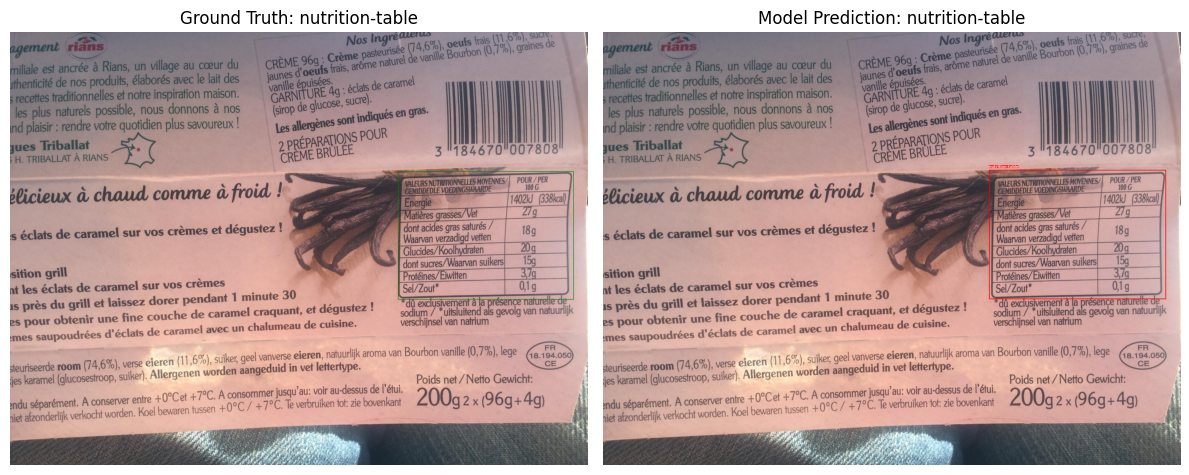

In [ ]:
# TASK: test on the #20 training example
from qwen_vl_utils import process_vision_info
import matplotlib.pyplot as plt
from PIL import ImageDraw

# Get example #20 from training set
example_idx = 20
example = train_dataset[example_idx]
image = example['image']
ground_truth_bbox = example['objects']['bbox'][0]
ground_truth_category = example['objects']['category_name'][0]

# Create messages for inference
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {
                "type": "text",
                "text": "Detect the bounding box of the nutrition table.",
            },
        ],
    }
]

# Apply chat template
text = processor_finetuned.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

# Process vision information
image_inputs, video_inputs = process_vision_info(messages)

# Prepare inputs
inputs = processor_finetuned(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to(model_finetuned.device)

# Generate prediction
with torch.no_grad():
    generated_ids = model_finetuned.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,
    )

# Decode the output
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor_finetuned.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

print(f"Example #{example_idx}")
print(f"Ground truth category: {ground_truth_category}")
print(f"Ground truth bbox (normalized): {ground_truth_bbox}")
print(f"\nModel output: {output_text}")

# Parse the model output
parsed_bbox = parse_qwen_bbox_output(output_text)
if parsed_bbox:
    print(f"Parsed prediction: {parsed_bbox}")

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Ground truth
img_gt = image.copy()
draw_gt = ImageDraw.Draw(img_gt)
width, height = img_gt.size
# CRITICAL: OpenFoodFacts uses [y_min, x_min, y_max, x_max] format
y_min, x_min, y_max, x_max = ground_truth_bbox
x_min = x_min * width
y_min = y_min * height
x_max = x_max * width
y_max = y_max * height
draw_gt.rectangle([x_min, y_min, x_max, y_max], outline='green', width=3)

axes[0].imshow(img_gt)
axes[0].set_title(f"Ground Truth: {ground_truth_category}")
axes[0].axis('off')

# Model prediction
if parsed_bbox:
    img_pred = visualize_bbox_on_image(image, parsed_bbox, normalize_coords=True)
    axes[1].imshow(img_pred)
    axes[1].set_title(f"Model Prediction: {parsed_bbox['object']}")
else:
    axes[1].imshow(image)
    axes[1].set_title("Model Prediction: No detection")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Since this sample is drawn from the training set, the model has encountered it during training, which may be seen as a form of cheating. To gain a more comprehensive understanding of the model's performance, you should also evaluate it using the eval dataset. For this, write an evaluation script that measures the IoU metric between the ground truth box and the predicted boundig box.



Evaluating fine-tuned model on validation set...


Evaluating: 100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


Fine-tuned Model Evaluation Results:
  Mean IoU: 0.7882
  Median IoU: 0.9316
  Detection Rate: 100.00%
  IoU > 0.5: 84.00%
  IoU > 0.7: 74.00%


<Figure size 1000x600 with 0 Axes>

(array([ 1.,  0.,  0.,  1.,  2.,  3.,  0.,  1.,  0.,  0.,  1.,  1.,  3.,
         0.,  0.,  3.,  1.,  3.,  9., 21.]),
 array([0.        , 0.04990005, 0.0998001 , 0.14970016, 0.19960021,
        0.24950026, 0.29940031, 0.34930036, 0.39920042, 0.44910047,
        0.49900052, 0.54890057, 0.59880062, 0.64870068, 0.69860073,
        0.74850078, 0.79840083, 0.84830088, 0.89820094, 0.94810099,
        0.99800104]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'IoU Score')

Text(0, 0.5, 'Number of Samples')

Text(0.5, 1.0, 'Distribution of IoU Scores - Fine-tuned Model')

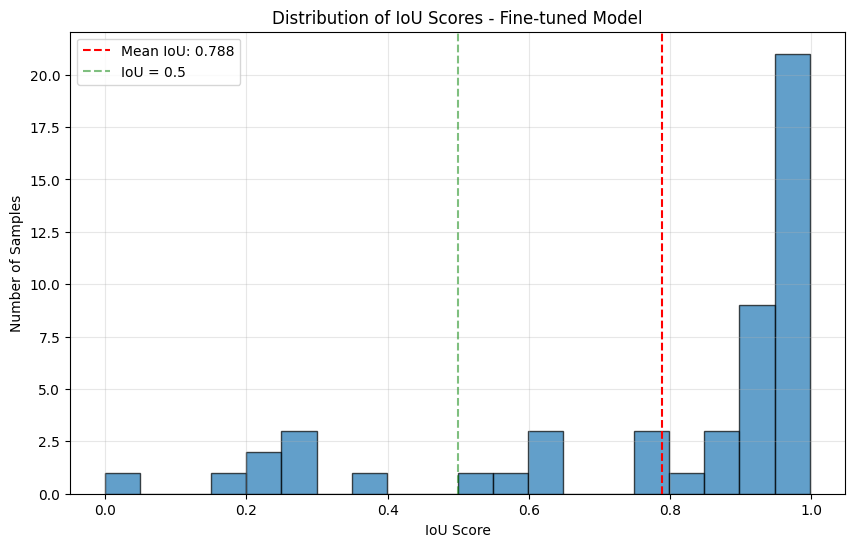

In [ ]:
# Task: write the eval function. You can use use ops.box_iou
from torchvision import ops
import numpy as np
from tqdm import tqdm

def evaluate_model(model, processor_model, dataset, num_samples=50):
    """
    Evaluate the model on a dataset using IoU metric.
    
    Args:
        model: The model to evaluate
        processor_model: The processor for the model
        dataset: The evaluation dataset
        num_samples: Number of samples to evaluate
        
    Returns:
        Dict with evaluation metrics
    """
    ious = []
    successful_detections = 0
    total_samples = min(num_samples, len(dataset))
    
    for idx in tqdm(range(total_samples), desc="Evaluating"):
        example = dataset[idx]
        image = example['image']
        ground_truth_bbox = example['objects']['bbox'][0]  # Take first bbox
        
        # Create messages for inference
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": "Detect the bounding box of the nutrition table."},
                ],
            }
        ]
        
        try:
            # Apply chat template
            text = processor_model.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            
            # Process vision information
            image_inputs, video_inputs = process_vision_info(messages)
            
            # Prepare inputs
            inputs = processor_model(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt"
            ).to(model.device)
            
            # Generate prediction
            with torch.no_grad():
                generated_ids = model.generate(
                    **inputs,
                    max_new_tokens=128,
                    do_sample=False,
                )
            
            # Decode output
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor_model.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]
            
            # Parse the model output
            parsed_bbox = parse_qwen_bbox_output(output_text)
            
            if parsed_bbox:
                successful_detections += 1
                
                # Convert predicted bbox from Qwen format (1000x1000) to normalized [0,1]
                if isinstance(parsed_bbox, list):
                    pred_bbox = parsed_bbox[0]['bbox']
                else:
                    pred_bbox = parsed_bbox['bbox']
                
                # Normalize predicted bbox from 1000x1000 to 0-1
                pred_bbox_norm = [
                    pred_bbox[0] / 1000.0,
                    pred_bbox[1] / 1000.0,
                    pred_bbox[2] / 1000.0,
                    pred_bbox[3] / 1000.0
                ]
                
                # Convert to tensor for IoU calculation
                # CRITICAL: Convert ground_truth from [y_min, x_min, y_max, x_max] to [x_min, y_min, x_max, y_max]
                # because torch.ops.box_iou expects [x_min, y_min, x_max, y_max] format
                y_min_gt, x_min_gt, y_max_gt, x_max_gt = ground_truth_bbox
                gt_tensor = torch.tensor([[x_min_gt, y_min_gt, x_max_gt, y_max_gt]], dtype=torch.float32)
                
                # pred_bbox_norm is already in [x_min, y_min, x_max, y_max] format from Qwen output
                pred_tensor = torch.tensor([[pred_bbox_norm[0], pred_bbox_norm[1],
                                           pred_bbox_norm[2], pred_bbox_norm[3]]], dtype=torch.float32)
                
                # Calculate IoU
                iou = ops.box_iou(pred_tensor, gt_tensor).item()
                ious.append(iou)
            else:
                ious.append(0.0)  # No detection counts as 0 IoU
                
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            ious.append(0.0)
    
    # Calculate metrics
    metrics = {
        "mean_iou": np.mean(ious) if ious else 0.0,
        "median_iou": np.median(ious) if ious else 0.0,
        "max_iou": np.max(ious) if ious else 0.0,
        "min_iou": np.min(ious) if ious else 0.0,
        "detection_rate": successful_detections / total_samples,
        "samples_evaluated": total_samples,
        "iou_threshold_0.5": sum(1 for iou in ious if iou > 0.5) / total_samples,
        "iou_threshold_0.7": sum(1 for iou in ious if iou > 0.7) / total_samples,
    }
    
    return metrics, ious

# Evaluate the fine-tuned model
print("\nEvaluating fine-tuned model on validation set...")
metrics_finetuned, ious_finetuned = evaluate_model(
    model_finetuned, 
    processor_finetuned, 
    eval_dataset, 
    num_samples=50
)

print("\nFine-tuned Model Evaluation Results:")
print(f"  Mean IoU: {metrics_finetuned['mean_iou']:.4f}")
print(f"  Median IoU: {metrics_finetuned['median_iou']:.4f}")
print(f"  Detection Rate: {metrics_finetuned['detection_rate']:.2%}")
print(f"  IoU > 0.5: {metrics_finetuned['iou_threshold_0.5']:.2%}")
print(f"  IoU > 0.7: {metrics_finetuned['iou_threshold_0.7']:.2%}")

# Plot IoU distribution
plt.figure(figsize=(10, 6))
plt.hist(ious_finetuned, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('IoU Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of IoU Scores - Fine-tuned Model')
plt.axvline(metrics_finetuned['mean_iou'], color='red', linestyle='--', label=f"Mean IoU: {metrics_finetuned['mean_iou']:.3f}")
plt.axvline(0.5, color='green', linestyle='--', alpha=0.5, label='IoU = 0.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Do the same evaluation for the model without finetuning.


Loading base model for comparison...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating base model (without fine-tuning) on validation set...


Evaluating: 100%|██████████| 50/50 [03:58<00:00,  4.78s/it]


Base Model Evaluation Results (No Fine-tuning):
  Mean IoU: 0.0981
  Median IoU: 0.0000
  Detection Rate: 18.00%
  IoU > 0.5: 10.00%
  IoU > 0.7: 6.00%

COMPARISON: Fine-tuned vs Base Model
Mean IoU Improvement: 0.6901 (703.1% improvement)
Detection Rate Improvement: 82.00%
IoU > 0.5 Improvement: 74.00%


(array([41.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,
         0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([0.        , 0.04854915, 0.0970983 , 0.14564745, 0.19419659,
        0.24274574, 0.29129489, 0.33984404, 0.38839319, 0.43694234,
        0.48549148, 0.53404063, 0.58258978, 0.63113893, 0.67968808,
        0.72823723, 0.77678638, 0.82533552, 0.87388467, 0.92243382,
        0.97098297]),
 <BarContainer object of 20 artists>)

(array([ 1.,  0.,  0.,  1.,  2.,  3.,  0.,  1.,  0.,  0.,  1.,  1.,  3.,
         0.,  0.,  3.,  1.,  3.,  9., 21.]),
 array([0.        , 0.04990005, 0.0998001 , 0.14970016, 0.19960021,
        0.24950026, 0.29940031, 0.34930036, 0.39920042, 0.44910047,
        0.49900052, 0.54890057, 0.59880062, 0.64870068, 0.69860073,
        0.74850078, 0.79840083, 0.84830088, 0.89820094, 0.94810099,
        0.99800104]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'IoU Score')

Text(0, 0.5, 'Number of Samples')

Text(0.5, 1.0, 'IoU Distribution Comparison')

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

Text(0.5, 0, 'Metrics')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Model Performance Comparison')

[Text(0, 0, 'Mean IoU'),
 Text(1, 0, 'Detection Rate'),
 Text(2, 0, 'IoU > 0.5'),
 Text(3, 0, 'IoU > 0.7')]

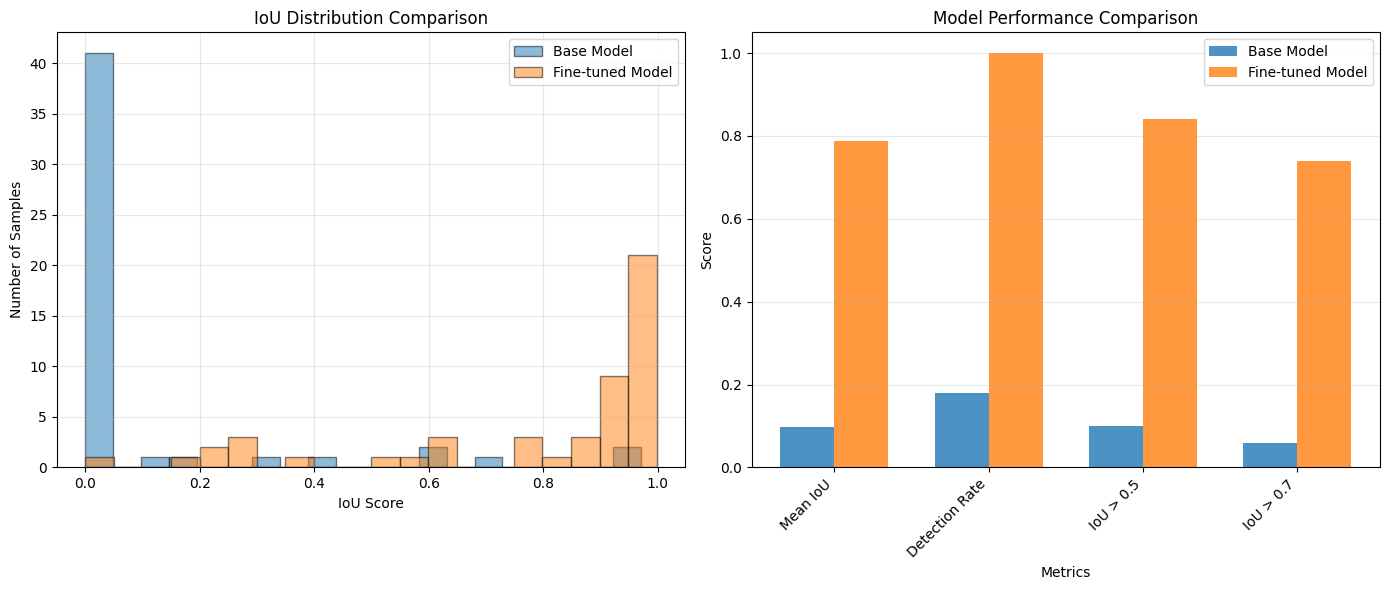

Deleted base_model and base_processor, but keeping model and processor for later use


In [ ]:
# Evaluate base model without fine-tuning
print("\nLoading base model for comparison...")
base_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="balanced",  # Use balanced for multi-GPU consistency
    attn_implementation="flash_attention_2",
)
base_processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

print("\nEvaluating base model (without fine-tuning) on validation set...")
metrics_base, ious_base = evaluate_model(
    base_model,
    base_processor,
    eval_dataset,
    num_samples=50
)

print("\nBase Model Evaluation Results (No Fine-tuning):")
print(f"  Mean IoU: {metrics_base['mean_iou']:.4f}")
print(f"  Median IoU: {metrics_base['median_iou']:.4f}")
print(f"  Detection Rate: {metrics_base['detection_rate']:.2%}")
print(f"  IoU > 0.5: {metrics_base['iou_threshold_0.5']:.2%}")
print(f"  IoU > 0.7: {metrics_base['iou_threshold_0.7']:.2%}")

# Compare results
print("\n" + "="*50)
print("COMPARISON: Fine-tuned vs Base Model")
print("="*50)
print(f"Mean IoU Improvement: {(metrics_finetuned['mean_iou'] - metrics_base['mean_iou']):.4f} "
      f"({((metrics_finetuned['mean_iou'] - metrics_base['mean_iou']) / max(metrics_base['mean_iou'], 0.001) * 100):.1f}% improvement)")
print(f"Detection Rate Improvement: {(metrics_finetuned['detection_rate'] - metrics_base['detection_rate']):.2%}")
print(f"IoU > 0.5 Improvement: {(metrics_finetuned['iou_threshold_0.5'] - metrics_base['iou_threshold_0.5']):.2%}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# IoU distribution comparison
_ = axes[0].hist(ious_base, bins=20, alpha=0.5, label='Base Model', edgecolor='black')
_ = axes[0].hist(ious_finetuned, bins=20, alpha=0.5, label='Fine-tuned Model', edgecolor='black')
_ = axes[0].set_xlabel('IoU Score')
_ = axes[0].set_ylabel('Number of Samples')
_ = axes[0].set_title('IoU Distribution Comparison')
_ = axes[0].legend()
_ = axes[0].grid(True, alpha=0.3)

# Metrics comparison bar chart
metrics_names = ['Mean IoU', 'Detection Rate', 'IoU > 0.5', 'IoU > 0.7']
base_values = [
    metrics_base['mean_iou'],
    metrics_base['detection_rate'],
    metrics_base['iou_threshold_0.5'],
    metrics_base['iou_threshold_0.7']
]
finetuned_values = [
    metrics_finetuned['mean_iou'],
    metrics_finetuned['detection_rate'],
    metrics_finetuned['iou_threshold_0.5'],
    metrics_finetuned['iou_threshold_0.7']
]

x = np.arange(len(metrics_names))
width = 0.35

_ = axes[1].bar(x - width/2, base_values, width, label='Base Model', alpha=0.8)
_ = axes[1].bar(x + width/2, finetuned_values, width, label='Fine-tuned Model', alpha=0.8)
_ = axes[1].set_xlabel('Metrics')
_ = axes[1].set_ylabel('Score')
_ = axes[1].set_title('Model Performance Comparison')
_ = axes[1].set_xticks(x)
_ = axes[1].set_xticklabels(metrics_names, rotation=45, ha='right')
_ = axes[1].legend()
_ = axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Clean up base model to free memory
del base_model
del base_processor
# COMMENTED OUT: This deletes model and processor which we need for later cells!
# clear_memory()
print("Deleted base_model and base_processor, but keeping model and processor for later use")

# 🧑‍🍳 [Optional]  The recipe
For the best model accuracy, one can first finetune the vision encoder while freezing the LLM. Then, we can use the ckpt above and finetune the model by applying LoRA to vision encoder and QLoRA to LLM.

# 🔀 Merge LoRA
After fine-tuning with LoRA, the adapter weights can be merged back into the base model, effectively eliminating the overhead of LoRA modules during inference. This fusion produces a standalone model suitable for efficient deployment.

# 🚀 Deployment

Try to export your trained model (with merged LoRA weights) to vLLM and then deploy into Nvidia triton!

In [ ]:
# Optional: Merge LoRA weights into base model for deployment
print("\nMerging LoRA weights into base model for deployment...")
merged_model = model_finetuned.merge_and_unload()

# Save the merged model to SSD
merged_output_dir = "/ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-merged"
merged_model.save_pretrained(merged_output_dir)
processor_finetuned.save_pretrained(merged_output_dir)

print(f"Merged model saved to {merged_output_dir}")
print("This model can now be loaded without PEFT and used for efficient inference.")


Merging LoRA weights into base model for deployment...


[]

Merged model saved to /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-merged
This model can now be loaded without PEFT and used for efficient inference.


## Bonus

For Qwen2-VL, implement a custom collate_fn that restricts loss computation to the answer portion only, explicitly excluding the system prompt and question from the loss.

In [ ]:
# Bonus: Custom collate function with loss only on answer portion

# =============================================================================
# DELETED FOR CLEANNESS: collate_fn_fixed_2, debug_collate_fn
#
# For reference:
#   - Import: from src.data.collators import collate_fn_fixed_2, debug_collate_fn
#   - Or copy from: src/data/collators.py (under "BACKUP/DRAFT COLLATORS" section)
#
# Original structure:
#   def collate_fn_fixed_2(batch):           # ~265 lines - verbose debug collator with improved label masking
#   def debug_collate_fn(collate_fn, ...):   # ~106 lines - debug helper to test collators and verify training tokens
#
# Example usage (after importing):
#   # from src.data.collators import collate_fn_fixed_2, debug_collate_fn
#   # test_output = debug_collate_fn(collate_fn_fixed_2, train_dataset_formatted, num_samples=2)
# =============================================================================

In [ ]:
# Clean collate_fn_fixed_3 class that only trains on assistant responses
class collate_fn_fixed_3:
    """
    Clean collator that masks everything except assistant responses.
    This ensures the model only learns the actual detection task (bbox coordinates)
    rather than memorizing static prompts.
    
    Key features:
    - Masks all padding, vision, system, and user tokens
    - Only trains on assistant response tokens
    - No OOV complexity - keeps it simple
    - Proper class structure with processor and model passed in __init__
    """
    
    def __init__(self, processor, model):
        self.processor = processor
        self.model = model
        
        # Track special tokens to mask
        self.pad_token_id = self.processor.tokenizer.pad_token_id
        self.vision_token_ids = [
            self.processor.tokenizer.convert_tokens_to_ids('<|vision_start|>'),
            self.processor.tokenizer.convert_tokens_to_ids('<|vision_end|>'),
            self.processor.tokenizer.convert_tokens_to_ids('<|image_pad|>')
        ]
        
        # Assistant markers for finding response boundaries
        self.assistant_start_token = "<|im_start|>assistant\n"
        self.assistant_end_token = "<|im_end|>"
        
        # For debugging - set to True to see first few samples
        self.debug = False
        self.debug_count = 0
        self.max_debug = 3
    
    def __call__(self, batch):
        # Step 1: Extract and prepare messages with actual images
        messages_list = [sample['messages'] for sample in batch]
        images_list = [sample.get('image', None) for sample in batch]
        
        # Filter out samples without images
        valid_pairs = [(m, img) for m, img in zip(messages_list, images_list) if img is not None]
        if not valid_pairs:
            raise ValueError("Batch contains no valid images.")
        
        messages_list, images_list = zip(*valid_pairs)
        messages_list = list(messages_list)
        images_list = list(images_list)
        
        # Process each sample to restore IMAGE_PLACEHOLDER with actual images
        all_conversations = []
        for messages, image in zip(messages_list, images_list):
            messages_with_image = []
            for msg in messages:
                msg_copy = {'role': msg['role'], 'content': []}
                
                for content_item in msg['content']:
                    if content_item is None:
                        continue
                    
                    # Process text content
                    if content_item.get('type') == 'text':
                        text_value = content_item.get('text')
                        if text_value is not None and text_value != 'None':
                            msg_copy['content'].append({
                                'type': 'text',
                                'text': text_value
                            })
                    # Process image content for user messages
                    elif content_item.get('type') == 'image' and msg['role'] == 'user':
                        image_value = content_item.get('image')
                        if image_value == 'IMAGE_PLACEHOLDER' or image_value is None:
                            msg_copy['content'].append({
                                'type': 'image',
                                'image': image  # Use actual PIL image
                            })
                        elif image_value and image_value != 'None':
                            msg_copy['content'].append({
                                'type': 'image',
                                'image': image_value
                            })
                
                if msg_copy['content']:
                    messages_with_image.append(msg_copy)
            
            all_conversations.append(messages_with_image)
        
        # Step 2: Apply chat template
        texts = self.processor.apply_chat_template(
            all_conversations,
            tokenize=False,
            add_generation_prompt=False
        )
        
        # Step 3: Process vision info
        images, videos = process_vision_info(all_conversations)
        
        # Step 4: Tokenize and process
        batch_inputs = self.processor(
            text=texts,
            images=images,
            padding=True,
            truncation=False,
            return_tensors="pt"
        )
        
        # Step 5: Create labels - start with everything masked
        labels = batch_inputs["input_ids"].clone()
        labels[:, :] = -100  # Mask everything initially
        
        # Step 6: Find and unmask ONLY assistant responses
        for batch_idx, text in enumerate(texts):
            input_ids = batch_inputs["input_ids"][batch_idx]
            
            # Find assistant response boundaries in the text
            assistant_start_pos = text.find(self.assistant_start_token)
            if assistant_start_pos == -1:
                # Try without newline
                assistant_start_pos = text.find("<|im_start|>assistant")
            
            if assistant_start_pos != -1:
                # Find where actual response starts (after the marker)
                response_start_in_text = assistant_start_pos + len(self.assistant_start_token)
                
                # Find end of assistant response
                assistant_end_pos = text.find(self.assistant_end_token, response_start_in_text)
                
                if assistant_end_pos != -1:
                    # Extract just the response text
                    response_text = text[response_start_in_text:assistant_end_pos]
                    
                    # Tokenize the response to find it in input_ids
                    response_tokens = self.processor.tokenizer.encode(
                        response_text, 
                        add_special_tokens=False
                    )
                    
                    if response_tokens:
                        # Find this sequence in the full input_ids
                        for i in range(len(input_ids) - len(response_tokens) + 1):
                            if input_ids[i:i+len(response_tokens)].tolist() == response_tokens:
                                # Unmask these tokens for training
                                labels[batch_idx, i:i+len(response_tokens)] = input_ids[i:i+len(response_tokens)]
                                break
        
        # Step 7: Debug output (only for first few samples)
        if self.debug and self.debug_count < self.max_debug:
            self.debug_count += 1
            non_masked = (labels != -100).sum().item()
            total = labels.numel()
            if non_masked > 0:
                # Decode what we're training on
                sample_labels = labels[0]
                trained_indices = (sample_labels != -100).nonzero(as_tuple=True)[0]
                if len(trained_indices) > 0:
                    trained_tokens = batch_inputs["input_ids"][0][trained_indices]
                    decoded = self.processor.tokenizer.decode(trained_tokens, skip_special_tokens=False)
                    print(f"[collate_fn_fixed_3] Sample {self.debug_count}: Training on {len(trained_indices)} tokens")
                    print(f"  Content: '{decoded}'")
                    print(f"  This is {100*len(trained_indices)/len(sample_labels):.1f}% of {len(sample_labels)} total tokens")
        
        batch_inputs["labels"] = labels
        return batch_inputs

print("✅ Created collate_fn_fixed_3 - clean assistant-only training")

# =============================================================================
# DELETED FOR CLEANNESS: test_collate_fn_fixed_3
#
# For reference:
#   - Import: from src.data.collators import test_collate_fn_fixed_3
#   - Or copy from: src/data/collators.py (under "BACKUP/DRAFT COLLATORS" section)
#
# Original structure:
#   def test_collate_fn_fixed_3():  # ~65 lines - test function for coordinate scaling verification
#
# Example usage (after importing):
#   # from src.data.collators import test_collate_fn_fixed_3
#   # test_collator = test_collate_fn_fixed_3()
# =============================================================================

✅ Created collate_fn_fixed_3 - clean assistant-only training


In [ ]:
# ================================================================================
# SECOND TRAINING RUN: Using collate_fn_fixed_3 (Assistant-Only Training)
# ================================================================================
print("\n" + "="*80)
print("SECOND TRAINING RUN: ASSISTANT-ONLY WITH collate_fn_fixed_3")
print("="*80)
print("""
This training run focuses ONLY on assistant responses (bbox coordinates),
ignoring system prompts and user messages. This should lead to:
- Better convergence on the actual detection task
- Lower training loss (training on ~30% of tokens instead of 100%)
- More efficient use of compute resources
""")


SECOND TRAINING RUN: ASSISTANT-ONLY WITH collate_fn_fixed_3

This training run focuses ONLY on assistant responses (bbox coordinates),
ignoring system prompts and user messages. This should lead to:
- Better convergence on the actual detection task
- Lower training loss (training on ~30% of tokens instead of 100%)
- More efficient use of compute resources



In [ ]:
# Clear GPU memory before starting second training
import torch
import gc

print("\n🧹 Clearing GPU memory before second training...")
torch.cuda.empty_cache()
gc.collect()
torch.cuda.synchronize()
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


🧹 Clearing GPU memory before second training...


23342

GPU allocated memory: 14.70 GB
GPU reserved memory: 22.79 GB


In [ ]:
# Create new training configuration for assistant-only training
from trl import SFTConfig

training_args_v3 = SFTConfig(
    # Output and logging - Different directory for comparison
    output_dir="/ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora-assistantonly",
    logging_dir="/ssd1/zhuoyuan/vlm_outputs/logs-assistantonly",
    logging_steps=10,  # Show training loss every 10 steps
    
    # Training hyperparameters (same as original for fair comparison)
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,  # Effective batch size = 16
    gradient_checkpointing=False,  # Disabled - causes issues with QLoRA
    
    # Learning rate and optimization (same as original)
    learning_rate=2e-5,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    optim="adamw_torch",
    adam_beta2=0.999,
    weight_decay=0.01,
    max_grad_norm=1.0,
    
    # Mixed precision and performance
    bf16=True,
    tf32=True,
    dataloader_num_workers=0,
    
    # Evaluation and saving
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    
    # Advanced options
    remove_unused_columns=False,
    label_names=["labels"],
    
    # Debugging / reporting
    report_to="wandb",  # Use W&B for consistency with first trainer
    run_name="qwen2vl-7b-assistant-only",  # Distinct run name for clear separation on W&B
    
    # TRL specific
    dataset_text_field=None,  # We handle formatting in collate_fn
    packing=False,
)

print("✅ Created new SFTConfig for assistant-only training")
print(f"   Output directory: {training_args_v3.output_dir}")

# Create a separate W&B run for assistant-only stage
try:
    import wandb as _wandb
    _wandb.finish()
    _wandb.init(
        project="qwen2vl-nutrition-detection",
        name="qwen2vl-7b-assistant-only",
        tags=["stage:assistant-only", "collator:v3", "qlora", "lora"],
    )
except Exception as _e:
    print(f"[warn] W&B re-init failed: {_e}")

✅ Created new SFTConfig for assistant-only training
   Output directory: /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora-assistantonly


eval/loss,█▂▁▁▁▁▁▁
eval/mean_token_accuracy,▁▇██████
eval/num_tokens,▁▂▃▄▅▆▇█
eval/runtime,▁▁▁▁▁▁▁█
eval/samples_per_second,███████▁
eval/steps_per_second,███████▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▆▆▅▅▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
train/learning_rate,▂▂▃▄▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train/loss,█▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
# Initialize collate_fn_fixed_3
print("\n📦 Initializing collate_fn_fixed_3...")

# Create instance of collate_fn_fixed_3
# Note: processor and model should be available from earlier training
collate_fn_v3 = collate_fn_fixed_3(processor, model)
collate_fn_v3.debug = True  # Enable debug output for first few samples
collate_fn_v3.max_debug = 5  # Show first 5 samples for verification

print("✅ collate_fn_fixed_3 initialized")
print("   - Will train ONLY on assistant responses")
print("   - Debug output enabled for first 5 samples")


📦 Initializing collate_fn_fixed_3...
✅ collate_fn_fixed_3 initialized
   - Will train ONLY on assistant responses
   - Debug output enabled for first 5 samples


In [ ]:
# Test the collator with a sample batch
print("\n🧪 Testing collate_fn_fixed_3 with a sample batch...")
test_batch = [train_dataset_formatted[0], train_dataset_formatted[1]]
test_output = collate_fn_v3(test_batch)

# Analyze what we're training on
labels = test_output['labels']
non_masked = (labels != -100).sum().item()
total = labels.numel()
print(f"\n📊 Training statistics:")
print(f"   - Total tokens in batch: {total}")
print(f"   - Tokens being trained on: {non_masked} ({100*non_masked/total:.1f}%)")
print(f"   - Tokens masked (ignored): {total - non_masked} ({100*(total-non_masked)/total:.1f}%)")

# Additional token distribution audits for assistant-only collator
print("\n📊 Token distribution (assistant-only) on train split...")
analyze_token_distribution(collate_fn_v3, train_dataset_formatted, num_samples=3)
print("\n📊 Token distribution (assistant-only) on validation split...")
analyze_token_distribution(collate_fn_v3, eval_dataset_formatted, num_samples=3)


🧪 Testing collate_fn_fixed_3 with a sample batch...


[collate_fn_fixed_3] Sample 1: Training on 21 tokens
  Content: '<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(14,57),(991,603)<|box_end|>'
  This is 1.6% of 1331 total tokens

📊 Training statistics:
   - Total tokens in batch: 2662
   - Tokens being trained on: 44 (1.7%)
   - Tokens masked (ignored): 2618 (98.3%)

📊 Token distribution (assistant-only) on train split...

TOKEN DISTRIBUTION ANALYSIS
Analyzing 3 samples to understand training tokens...

[collate_fn_fixed_3] Sample 2: Training on 21 tokens
  Content: '<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(14,57),(991,603)<|box_end|>'
  This is 1.6% of 1331 total tokens
Sample 1:
  Total tokens: 1331
  Masked (ignored): 1310 tokens
  Trained on: 21 tokens (1.6%)
<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(14,57),(991,603)<|box_end|>

[collate_fn_fixed_3] Sample 3: Training on 23 tokens
  Content: '<|object_ref_start|>nutrition-table<|object_ref_end|><|box_start|>(147,

In [ ]:
# Create the second SFTTrainer
from trl import SFTTrainer

print("\n🎯 Creating second SFTTrainer with assistant-only training...")

# BUG FIX (2025-11-25): Same fix as first trainer - pass peft_config instead of
# assuming model already has LoRA adapters. This prevents the double-preparation bug.
trainer_v3 = SFTTrainer(
    model=model,  # Base model - SFTTrainer will handle LoRA setup
    args=training_args_v3,
    train_dataset=train_dataset_formatted,
    eval_dataset=eval_dataset_formatted,
    data_collator=collate_fn_v3,  # Using collate_fn_fixed_3 for assistant-only
    processing_class=processor,
    peft_config=lora_config,  # BUG FIX: Let SFTTrainer handle LoRA setup properly
)

print("✅ Second SFTTrainer created successfully")
print(f"   Total training samples: {len(train_dataset_formatted)}")
print(f"   Total evaluation samples: {len(eval_dataset_formatted)}")
print(f"   Training with assistant-only collator (collate_fn_fixed_3)")

# Calculate training steps
steps_per_epoch = len(train_dataset_formatted) // (training_args_v3.per_device_train_batch_size * training_args_v3.gradient_accumulation_steps)
total_steps = steps_per_epoch * training_args_v3.num_train_epochs
print(f"   Steps per epoch: {steps_per_epoch}")
print(f"   Total training steps: {total_steps}")

# DEBUG: Check if LoRA parameters are trainable after SFTTrainer creation
print("\n" + "="*60)
print("CHECKING TRAINABLE PARAMETERS AFTER trainer_v3 CREATION")
print("="*60)
trainer_v3.model.print_trainable_parameters()
# If this shows 0 trainable params, the bug is still present

# =============================================================================
# COMMENTED OUT: Callback usage (requires import from src.training.callbacks)
#
# To re-enable:
#   from src.training.callbacks import GradNormCallback, IoUEvalCallback, ConsoleLogCallback
#
# _iou_cb_v3 = IoUEvalCallback(processor=processor, eval_dataset=eval_dataset, num_samples=24, prefix="eval")
# _iou_cb_v3.trainer = trainer_v3
# trainer_v3.add_callback(_iou_cb_v3)
# _grad_cb_v3 = GradNormCallback()
# _grad_cb_v3.trainer = trainer_v3
# trainer_v3.add_callback(_grad_cb_v3)
# trainer_v3.add_callback(ConsoleLogCallback())
# =============================================================================


🎯 Creating second SFTTrainer with assistant-only training...


/home/zhuoyuan/miniconda3/envs/vlm_Qwen2VL_object_detection/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/zhuoyuan/miniconda3/envs/vlm_Qwen2VL_object_detection/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


✅ Second SFTTrainer created successfully
   Total training samples: 1083
   Total evaluation samples: 123
   Training with assistant-only collator (collate_fn_fixed_3)
   Steps per epoch: 135
   Total training steps: 405

CHECKING TRAINABLE PARAMETERS AFTER trainer_v3 CREATION
trainable params: 161,480,704 || all params: 8,452,856,320 || trainable%: 1.9104


In [ ]:
# Launch the second training
print("\n" + "="*80)
print("🚀 LAUNCHING SECOND TRAINING (ASSISTANT-ONLY)")
print("="*80)
print("Training will focus only on learning the bbox coordinates...")
print("Watch for lower loss values compared to the first training run!")
print("")

# Train the model
trainer_v3.train()


🚀 LAUNCHING SECOND TRAINING (ASSISTANT-ONLY)
Training will focus only on learning the bbox coordinates...
Watch for lower loss values compared to the first training run!



Step,Training Loss,Validation Loss,Num Tokens,Mean Token Accuracy
100,0.704700,0.689873,1041372.000000,0.739071
200,0.644900,0.658234,2068051.000000,0.756815
300,0.596500,0.649345,3098490.000000,0.760070
400,0.541300,0.652425,4139529.000000,0.754619


TrainOutput(global_step=408, training_loss=0.7039188123216816, metrics={'train_runtime': 2892.478, 'train_samples_per_second': 1.123, 'train_steps_per_second': 0.141, 'total_flos': 2.000325974735186e+17, 'train_loss': 0.7039188123216816, 'epoch': 3.0})

In [ ]:
# Save the fine-tuned model
print("\n💾 Saving the assistant-only fine-tuned model...")
trainer_v3.save_model(training_args_v3.output_dir)
processor.save_pretrained(training_args_v3.output_dir)

print(f"✅ Model saved to: {training_args_v3.output_dir}")
print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print("\nYou now have two trained models:")
print(f"1. Original (all tokens): /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora")
print(f"2. Assistant-only: {training_args_v3.output_dir}")
print("\nCompare their performance to see which approach works better!")


💾 Saving the assistant-only fine-tuned model...


[]

✅ Model saved to: /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora-assistantonly

TRAINING COMPLETE!

You now have two trained models:
1. Original (all tokens): /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora
2. Assistant-only: /ssd1/zhuoyuan/vlm_outputs/qwen2vl-nutrition-detection-lora-assistantonly

Compare their performance to see which approach works better!


In [ ]:
# Load and evaluate v3 model
model_finetuned_v3 = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="balanced",
    attn_implementation="flash_attention_2",
)
model_finetuned_v3 = PeftModel.from_pretrained(
    model_finetuned_v3,
    training_args_v3.output_dir,
    torch_dtype=torch.bfloat16,
)
processor_finetuned_v3 = Qwen2VLProcessor.from_pretrained(training_args_v3.output_dir)

metrics_v3, ious_v3 = evaluate_model(
    model_finetuned_v3,
    processor_finetuned_v3,
    eval_dataset,
    num_samples=50
)

print("\nModel v3 IoU Statistics:")
print(f"  Mean IoU: {metrics_v3['mean_iou']:.4f}")
print(f"  Median IoU: {metrics_v3['median_iou']:.4f}")
print(f"  Detection Rate: {metrics_v3['detection_rate']:.2%}")
print(f"  IoU > 0.5: {metrics_v3['iou_threshold_0.5']:.2%}")
print(f"  IoU > 0.7: {metrics_v3['iou_threshold_0.7']:.2%}")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 50/50 [03:36<00:00,  4.33s/it]


Model v3 IoU Statistics:
  Mean IoU: 0.8109
  Median IoU: 0.9372
  Detection Rate: 100.00%
  IoU > 0.5: 90.00%
  IoU > 0.7: 78.00%
